In [1]:
%reload_ext autoreload
%autoreload 2

# Meta-analysis of benthic calcification rates

In [2]:
# custom imports
from calcification_meta_analysis.processing import process, climatology
from calcification_meta_analysis.plotting import (
    climatology as climatology_plot,
    analysis as analysis_plot,
    data_exploration,
)
from calcification_meta_analysis.analysis import metafor, analysis
from calcification_meta_analysis.utils import config

# generic
import pandas as pd

### Load calcification rates dataset

#### Processing steps

1. Carbonate chemistry calculation from measured parameters
2. Populating location information (from coordinates, or where unavailable, fetching from the Google Maps API)
3. Assigning treatment and control groups (minimum pH, maximum temperature, unless otherwise specified)
4. Calculating effect sizes

In [3]:
calcification_data_df = process.process_extracted_calcification_data(
    fp=config.data_dir / "Orlando_data.xlsx",
    sheet_name="all_calcification",
)

/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/NREE_persistence_reef_structures_meta_analysis/calcification_meta_analysis/processing/cleaning.py:69: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return df.replace(" ", np.nan).infer_objects(copy=False)
INFO:calcification_meta_analysis.processing.locations:Using cached locations in /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/NREE_persistence_reef_structures_meta_analysis/resources/gmaps_locations.yaml
INFO:calcification_meta_analysis.processing.locations:Dropped 151 row(s) for which latitude or longitude is NaN
INFO:calcification_meta_analysis.processing.taxonomy:Using species mapping in /Users/rt582/Library/

Calculating carbonate chemistry:   0%|          | 0/4673 [00:00<?, ?it/s]

INFO:calcification_meta_analysis.processing.carbonate_processing:Filled 18517.0 NaN values by combining dataframes


Assigning treatment groups:   0%|          | 0/367 [00:00<?, ?it/s]

Skipping 10.1371/journal.pone.0075049 because it has only one treatment (no control)
Skipping 10.7717/peerj.411_2009-LOC-A because it has only one treatment (no control)
Skipping 10.7717/peerj.411_2009-LOC-B because it has only one treatment (no control)
Skipping 10.7717/peerj.411_2010-LOC-A because it has only one treatment (no control)
Skipping 10.7717/peerj.411_2010-LOC-B because it has only one treatment (no control)
Removing 1 row with n=1


  0%|          | 0/159 [00:00<?, ?it/s]

/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/NREE_persistence_reef_structures_meta_analysis/calcification_meta_analysis/analysis/analysis.py:340: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(0, mean_value).infer_objects(copy=False)


In [4]:
# TODO: replace raw raw with cleaned raw
# # load raw extracted data
# extracted_calcification_data_fp = (
#     config.data_dir / "Orlando_data_pre_highlight_fix.xlsx"
# )
# # extracted_calcification_data_fp = (
# #     config.data_dir / "extracted_calcification_data copy.xlsx"
# # )
# extracted_calcification_data_df = pd.read_excel(extracted_calcification_data_fp)
# extracted_calcification_data_df.describe()

### Effect type choices

In [5]:
EFFECT_TYPE = "st_relative_calcification"

### Compare Python and native R compatability

The following cells train a few `metafor` models with different inputs, allowing comparison with identical models in the `alcification_meta_analysis/analysis/rnative/analysis.R` script (section starting at line 56).

The dataset is truncated to the first 200 rows to speed up model fitting.

The `metafor.MetaforModel` class is later used to forecast the calcification response to future climatology values. 


In [6]:
# raw model (no moderators) (line 61)
metafor_model = metafor.MetaforModel(
    calcification_data_df.head(200),
    effect_type=EFFECT_TYPE,
    formula=f"{EFFECT_TYPE} ~ 1",
    random="~ 1 | doi",
).fit_model()
metafor_model.view_model_summary()

INFO:calcification_meta_analysis.analysis.metafor:R DataFrame created with 200 rows
INFO:calcification_meta_analysis.analysis.metafor:Metafor initialized successfully
INFO:calcification_meta_analysis.analysis.metafor:Formula: st_relative_calcification ~ 1
INFO:calcification_meta_analysis.analysis.metafor:Treatment: ['phtot', 'temp', 'temp_phtot']
INFO:calcification_meta_analysis.analysis.metafor:Data shape: (200, 126)
INFO:calcification_meta_analysis.analysis.metafor:Fitting model with formula: st_relative_calcification ~ 1



----- PROCESSING SUMMARY -----
Treatment:  ['phtot', 'temp', 'temp_phtot']
Total samples in input data:  200
Total samples of relevant investigation:  200
Total samples dropped due to Cook's distance:  0
Dropped due to NaN values:  0
Dropped due to Cook's distance:  0
Final sample count: 200 (0 rows dropped)



  
  
  
INFO:calcification_meta_analysis.analysis.metafor:Extracted model components: ['method', 'k', 'QE', 'QEp', 'QM', 'QMp', 'pval', 'beta', 'se', 'zval', 'ci.lb', 'ci.ub', 'fit.stats', 'sigma2.1', 'sigma2']
INFO:calcification_meta_analysis.analysis.metafor:Model fitted successfully
INFO:calcification_meta_analysis.analysis.metafor:Components extracted: ['method', 'k', 'QE', 'QEp', 'QM', 'QMp', 'pval', 'beta', 'se', 'zval', 'ci.lb', 'ci.ub', 'fit.stats', 'sigma2.1', 'sigma2']



Multivariate Meta-Analysis Model (k = 200; method: REML)

    logLik    Deviance         AIC         BIC        AICc   
-1485.6132   2971.2264   2975.2264   2981.8130   2975.2876   

Variance Components:

              estim     sqrt  nlvls  fixed  factor 
sigma^2    832.8814  28.8597     20     no     doi 

Test for Heterogeneity:
Q(df = 199) = 1958.2390, p-val < .0001

Model Results:

estimate      se     zval    pval     ci.lb    ci.ub     
-22.3976  7.0553  -3.1746  0.0015  -36.2257  -8.5694  ** 

---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




In [7]:
# moderators model (line 66)
metafor_model = metafor.MetaforModel(
    calcification_data_df.head(200),
    effect_type=EFFECT_TYPE,
    formula=f"{EFFECT_TYPE} ~ delta_t + delta_ph - 1",
    random="~ 1 | doi",
).fit_model()
metafor_model.view_model_summary()


INFO:calcification_meta_analysis.analysis.metafor:R DataFrame created with 200 rows
INFO:calcification_meta_analysis.analysis.metafor:Metafor initialized successfully
INFO:calcification_meta_analysis.analysis.metafor:Formula: st_relative_calcification ~ delta_t + delta_ph - 1
INFO:calcification_meta_analysis.analysis.metafor:Treatment: ['phtot', 'temp', 'temp_phtot']
INFO:calcification_meta_analysis.analysis.metafor:Data shape: (200, 126)
INFO:calcification_meta_analysis.analysis.metafor:Fitting model with formula: st_relative_calcification ~ delta_t + delta_ph - 1



----- PROCESSING SUMMARY -----
Treatment:  ['phtot', 'temp', 'temp_phtot']
Total samples in input data:  200
Total samples of relevant investigation:  200
Total samples dropped due to Cook's distance:  0
Dropped due to NaN values:  0
Dropped due to Cook's distance:  0
Final sample count: 200 (0 rows dropped)



  
  
  
  
INFO:calcification_meta_analysis.analysis.metafor:Extracted model components: ['method', 'k', 'QE', 'QEp', 'QM', 'QMp', 'pval', 'beta', 'se', 'zval', 'ci.lb', 'ci.ub', 'fit.stats', 'sigma2.1', 'sigma2']
INFO:calcification_meta_analysis.analysis.metafor:Model fitted successfully
INFO:calcification_meta_analysis.analysis.metafor:Components extracted: ['method', 'k', 'QE', 'QEp', 'QM', 'QMp', 'pval', 'beta', 'se', 'zval', 'ci.lb', 'ci.ub', 'fit.stats', 'sigma2.1', 'sigma2']



Multivariate Meta-Analysis Model (k = 200; method: REML)

    logLik    Deviance         AIC         BIC        AICc   
-1404.0270   2808.0540   2814.0540   2823.9188   2814.1777   

Variance Components:

              estim     sqrt  nlvls  fixed  factor 
sigma^2    631.2396  25.1245     20     no     doi 

Test for Residual Heterogeneity:
QE(df = 198) = 1504.8066, p-val < .0001

Test of Moderators (coefficients 1:2):
QM(df = 2) = 171.3518, p-val < .0001

Model Results:

          estimate      se     zval    pval    ci.lb    ci.ub      
delta_t    -5.4898  0.7250  -7.5717  <.0001  -6.9108  -4.0687  *** 
delta_ph   41.2552  3.7689  10.9462  <.0001  33.8683  48.6420  *** 

---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




In [8]:
# changing random effect structure (line 71)
metafor_model = metafor.MetaforModel(
    calcification_data_df.head(200),
    effect_type=EFFECT_TYPE,
    formula=f"{EFFECT_TYPE} ~ delta_t + delta_ph - 1",
    random="~ 1 | doi/ID",
).fit_model()
metafor_model.view_model_summary()


INFO:calcification_meta_analysis.analysis.metafor:R DataFrame created with 200 rows
INFO:calcification_meta_analysis.analysis.metafor:Metafor initialized successfully
INFO:calcification_meta_analysis.analysis.metafor:Formula: st_relative_calcification ~ delta_t + delta_ph - 1
INFO:calcification_meta_analysis.analysis.metafor:Treatment: ['phtot', 'temp', 'temp_phtot']
INFO:calcification_meta_analysis.analysis.metafor:Data shape: (200, 126)
INFO:calcification_meta_analysis.analysis.metafor:Fitting model with formula: st_relative_calcification ~ delta_t + delta_ph - 1



----- PROCESSING SUMMARY -----
Treatment:  ['phtot', 'temp', 'temp_phtot']
Total samples in input data:  200
Total samples of relevant investigation:  200
Total samples dropped due to Cook's distance:  0
Dropped due to NaN values:  0
Dropped due to Cook's distance:  0
Final sample count: 200 (0 rows dropped)



  
  
  
  
INFO:calcification_meta_analysis.analysis.metafor:Extracted model components: ['method', 'k', 'QE', 'QEp', 'QM', 'QMp', 'pval', 'beta', 'se', 'zval', 'ci.lb', 'ci.ub', 'fit.stats', 'sigma2.1', 'sigma2.2', 'sigma2']
INFO:calcification_meta_analysis.analysis.metafor:Model fitted successfully
INFO:calcification_meta_analysis.analysis.metafor:Components extracted: ['method', 'k', 'QE', 'QEp', 'QM', 'QMp', 'pval', 'beta', 'se', 'zval', 'ci.lb', 'ci.ub', 'fit.stats', 'sigma2.1', 'sigma2.2', 'sigma2']



Multivariate Meta-Analysis Model (k = 200; method: REML)

    logLik    Deviance         AIC         BIC        AICc   
-1035.2529   2070.5059   2078.5059   2091.6590   2078.7131   

Variance Components:

              estim     sqrt  nlvls  fixed  factor 
sigma^2.1  538.7984  23.2120     20     no     doi 
sigma^2.2  975.1238  31.2270    200     no  doi/ID 

Test for Residual Heterogeneity:
QE(df = 198) = 1504.8066, p-val < .0001

Test of Moderators (coefficients 1:2):
QM(df = 2) = 39.5082, p-val < .0001

Model Results:

          estimate      se     zval    pval    ci.lb    ci.ub      
delta_t    -6.1889  1.6931  -3.6553  0.0003  -9.5073  -2.8705  *** 
delta_ph   50.7823  9.9885   5.0841  <.0001  31.2052  70.3594  *** 

---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




### Load climatology data

INFO:root:Loading climatology data...
/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/NREE_persistence_reef_structures_meta_analysis/calcification_meta_analysis/processing/climatology.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(
/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/NREE_persistence_reef_structures_meta_analysis/calcification_meta_analysis/processing/climatology.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcast

Generating batched anomalies for ph:   0%|          | 0/124 [00:00<?, ?it/s]

Generating batched anomalies for sst:   0%|          | 0/124 [00:00<?, ?it/s]

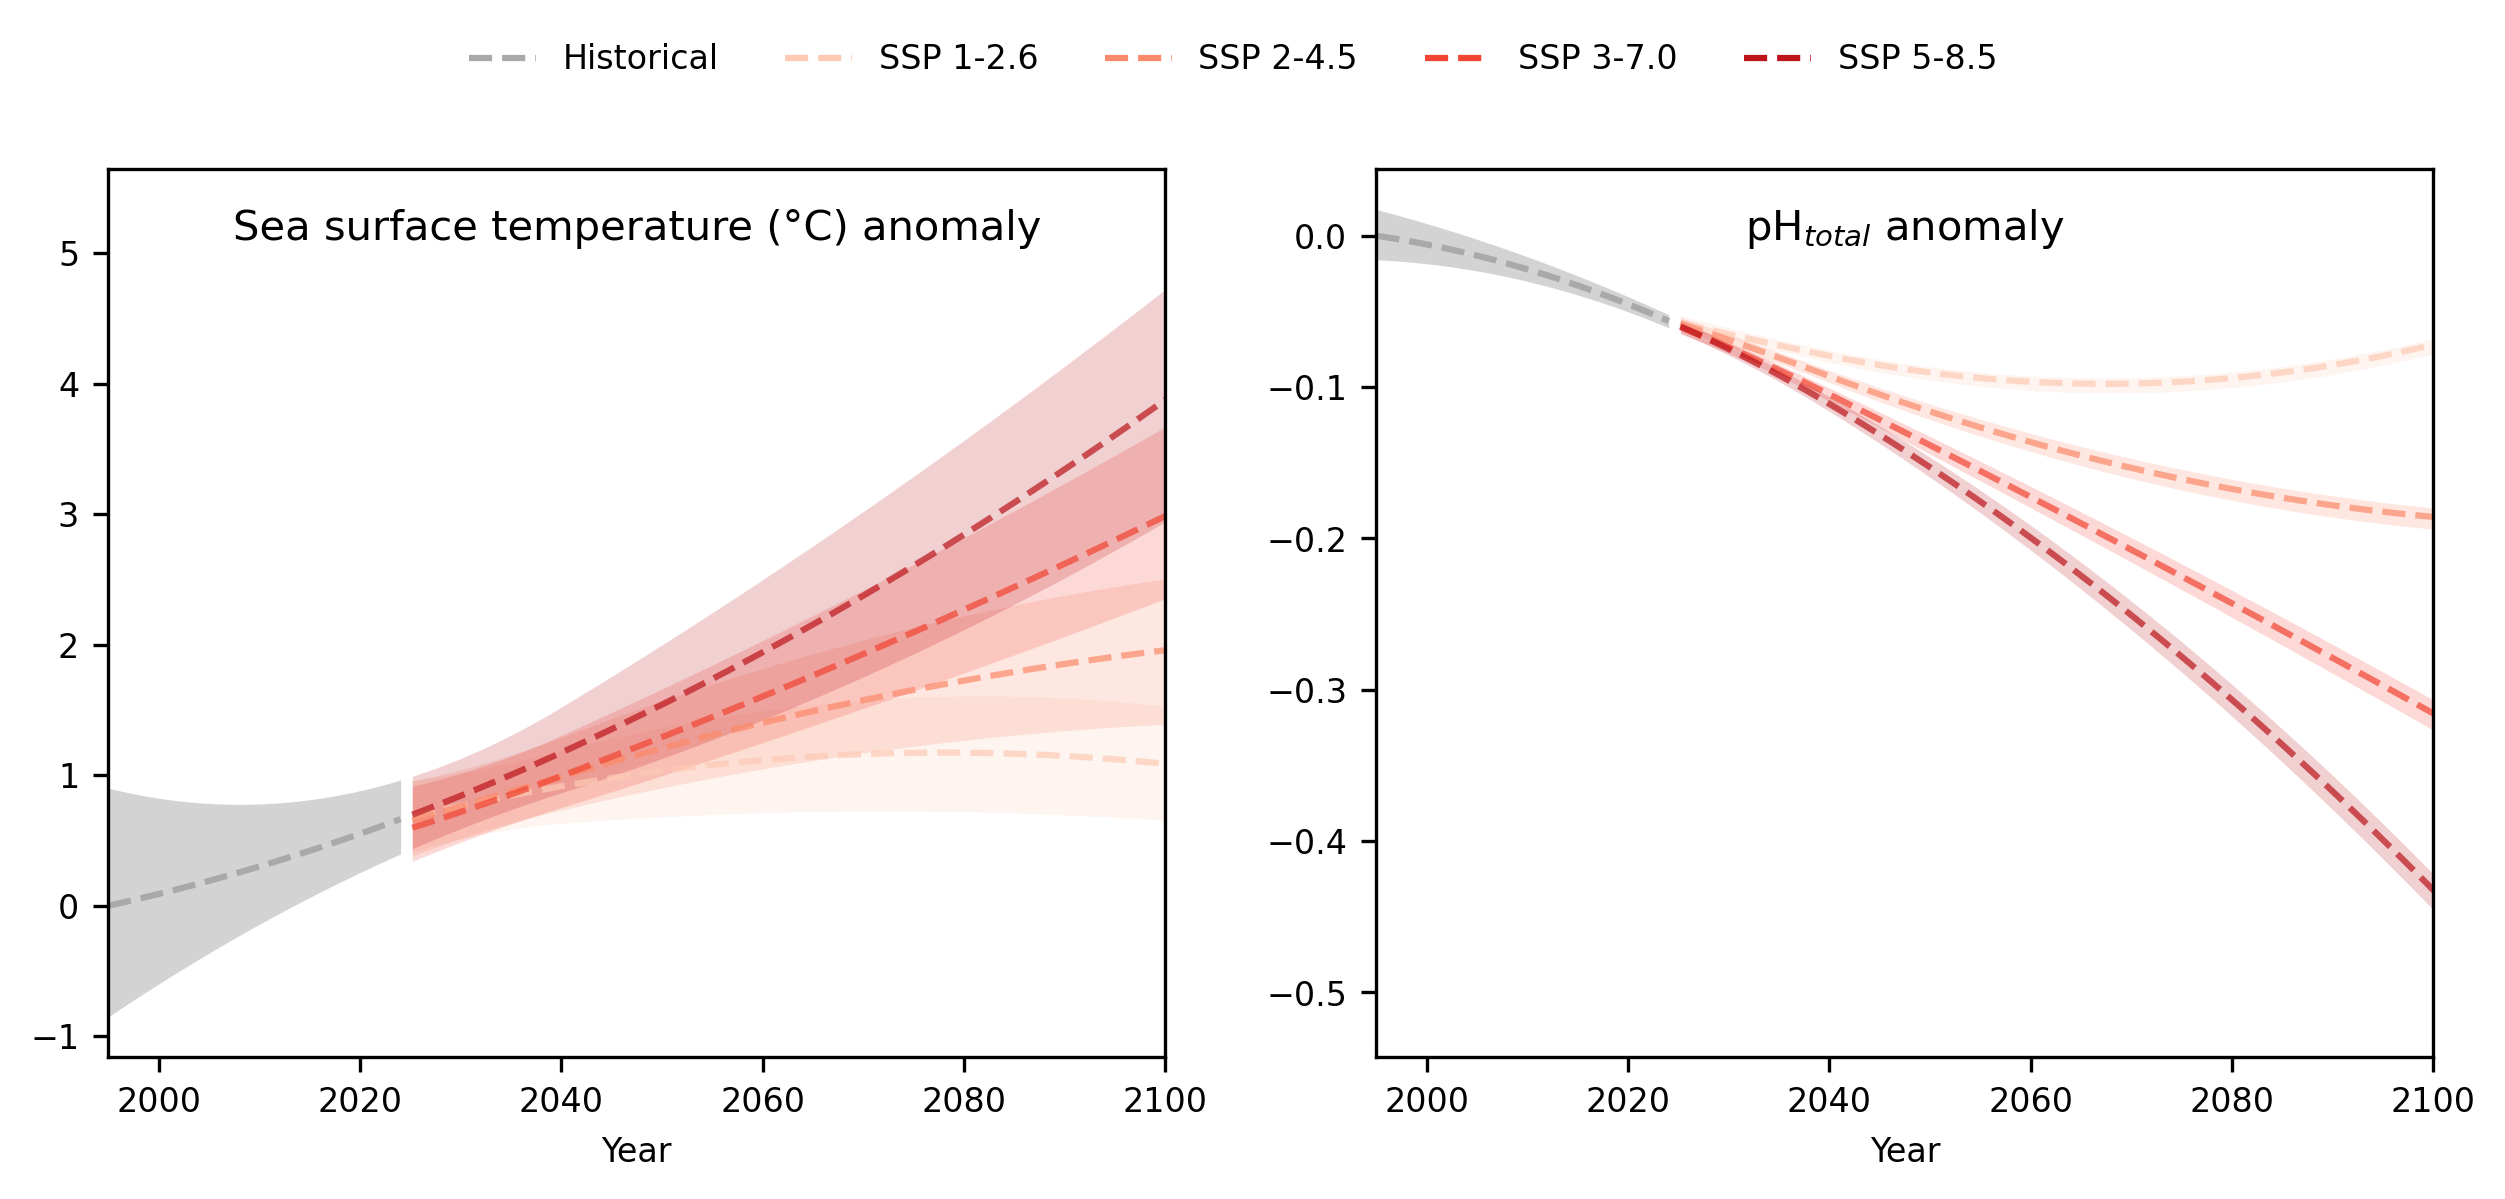

In [9]:
local_climatology_df, global_future_anomaly_df, global_anomaly_df = (
    process.process_climatology_data(
        calcification_data_df,
        config.climatology_data_dir / "ph_scenarios_output_table_site_locations.csv",
        config.climatology_data_dir / "sst_scenarios_output_table_site_locations.csv",
        config.resources_dir / "locations.yaml",
    )
)
# extrapolate climatology values to end of century
global_anomaly_df = climatology.extrapolate_df(global_anomaly_df)
# visualise climatologies until end of century
climatology_plot.plot_climate_anomalies(global_anomaly_df);

#### Filter measured calcification responses based on forecasted climatologies
To those lying within the limits of reasonable forecasts by the end of the century

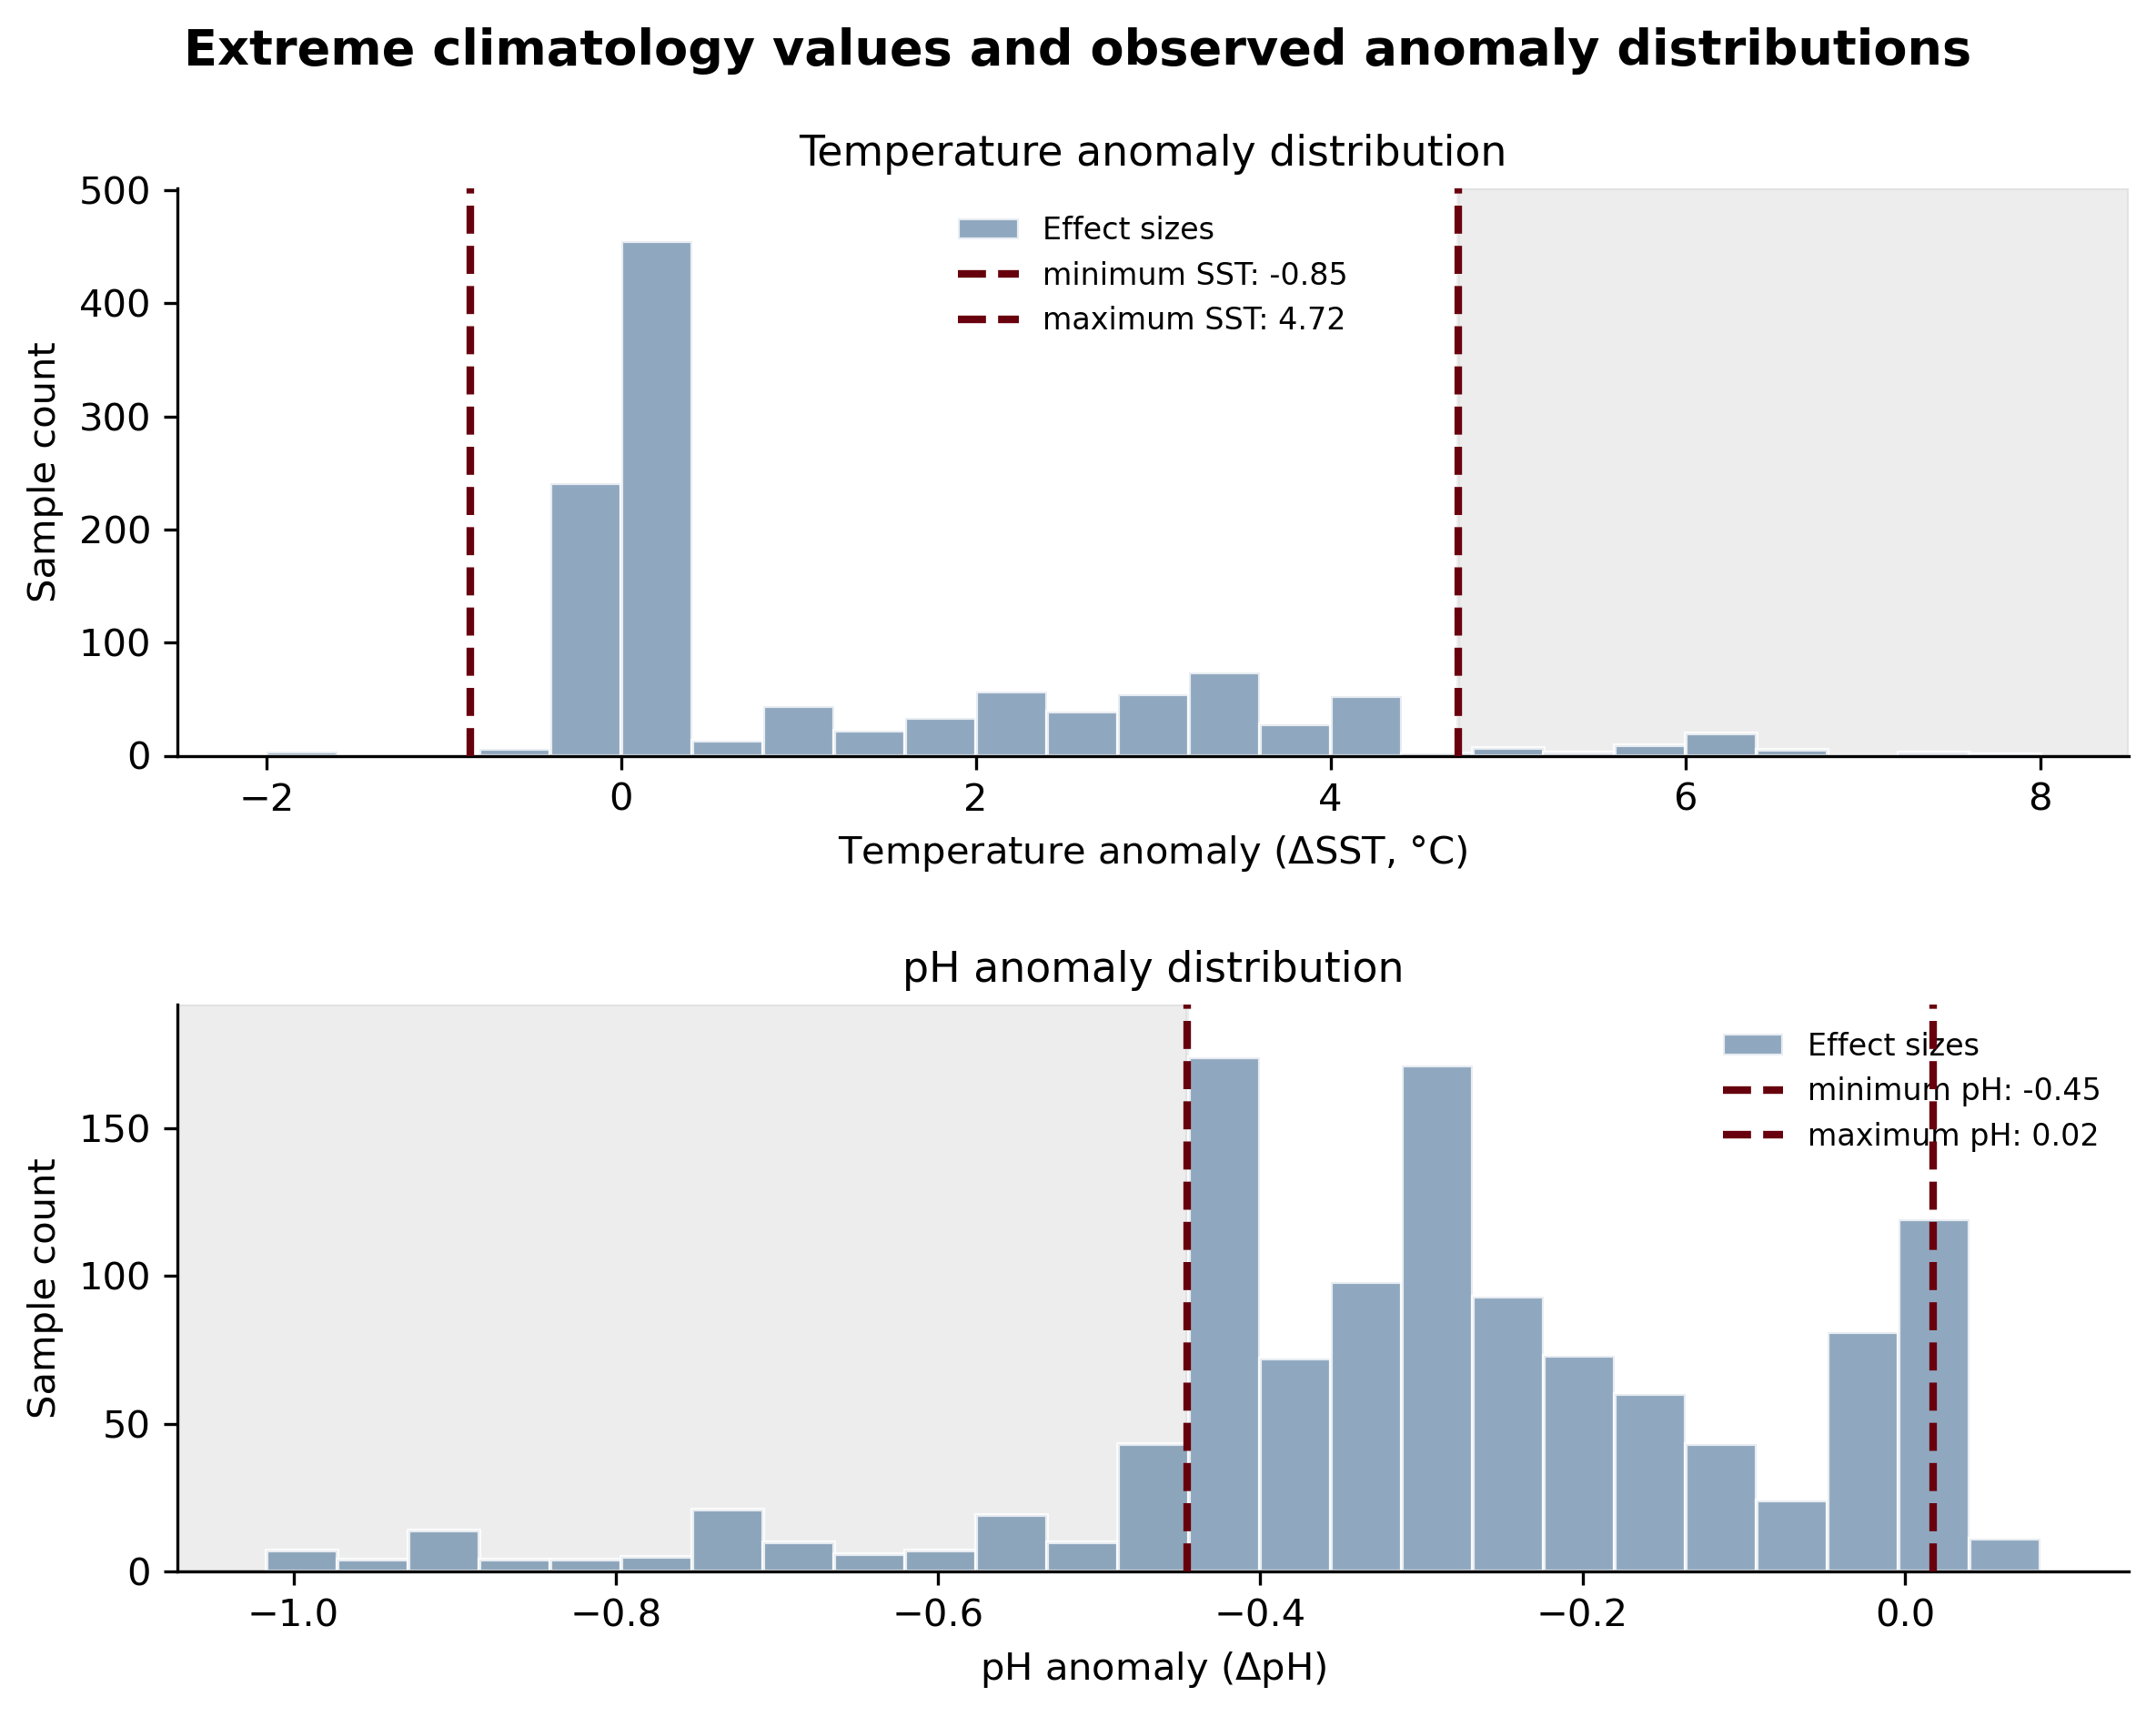

In [10]:
calcification_clim_filtered_data_df = climatology.filter_df_by_extreme_climatologies(
    calcification_data_df, global_anomaly_df
)
climatology_plot.plot_extreme_climatology_values(
    calcification_data_df, global_anomaly_df
);

## Exploring distribution of effect size

### Figure S1 – Visualising distribution effect sizes against climate anomalies

/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/NREE_persistence_reef_structures_meta_analysis/calcification_meta_analysis/plotting/data_exploration.py:534: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


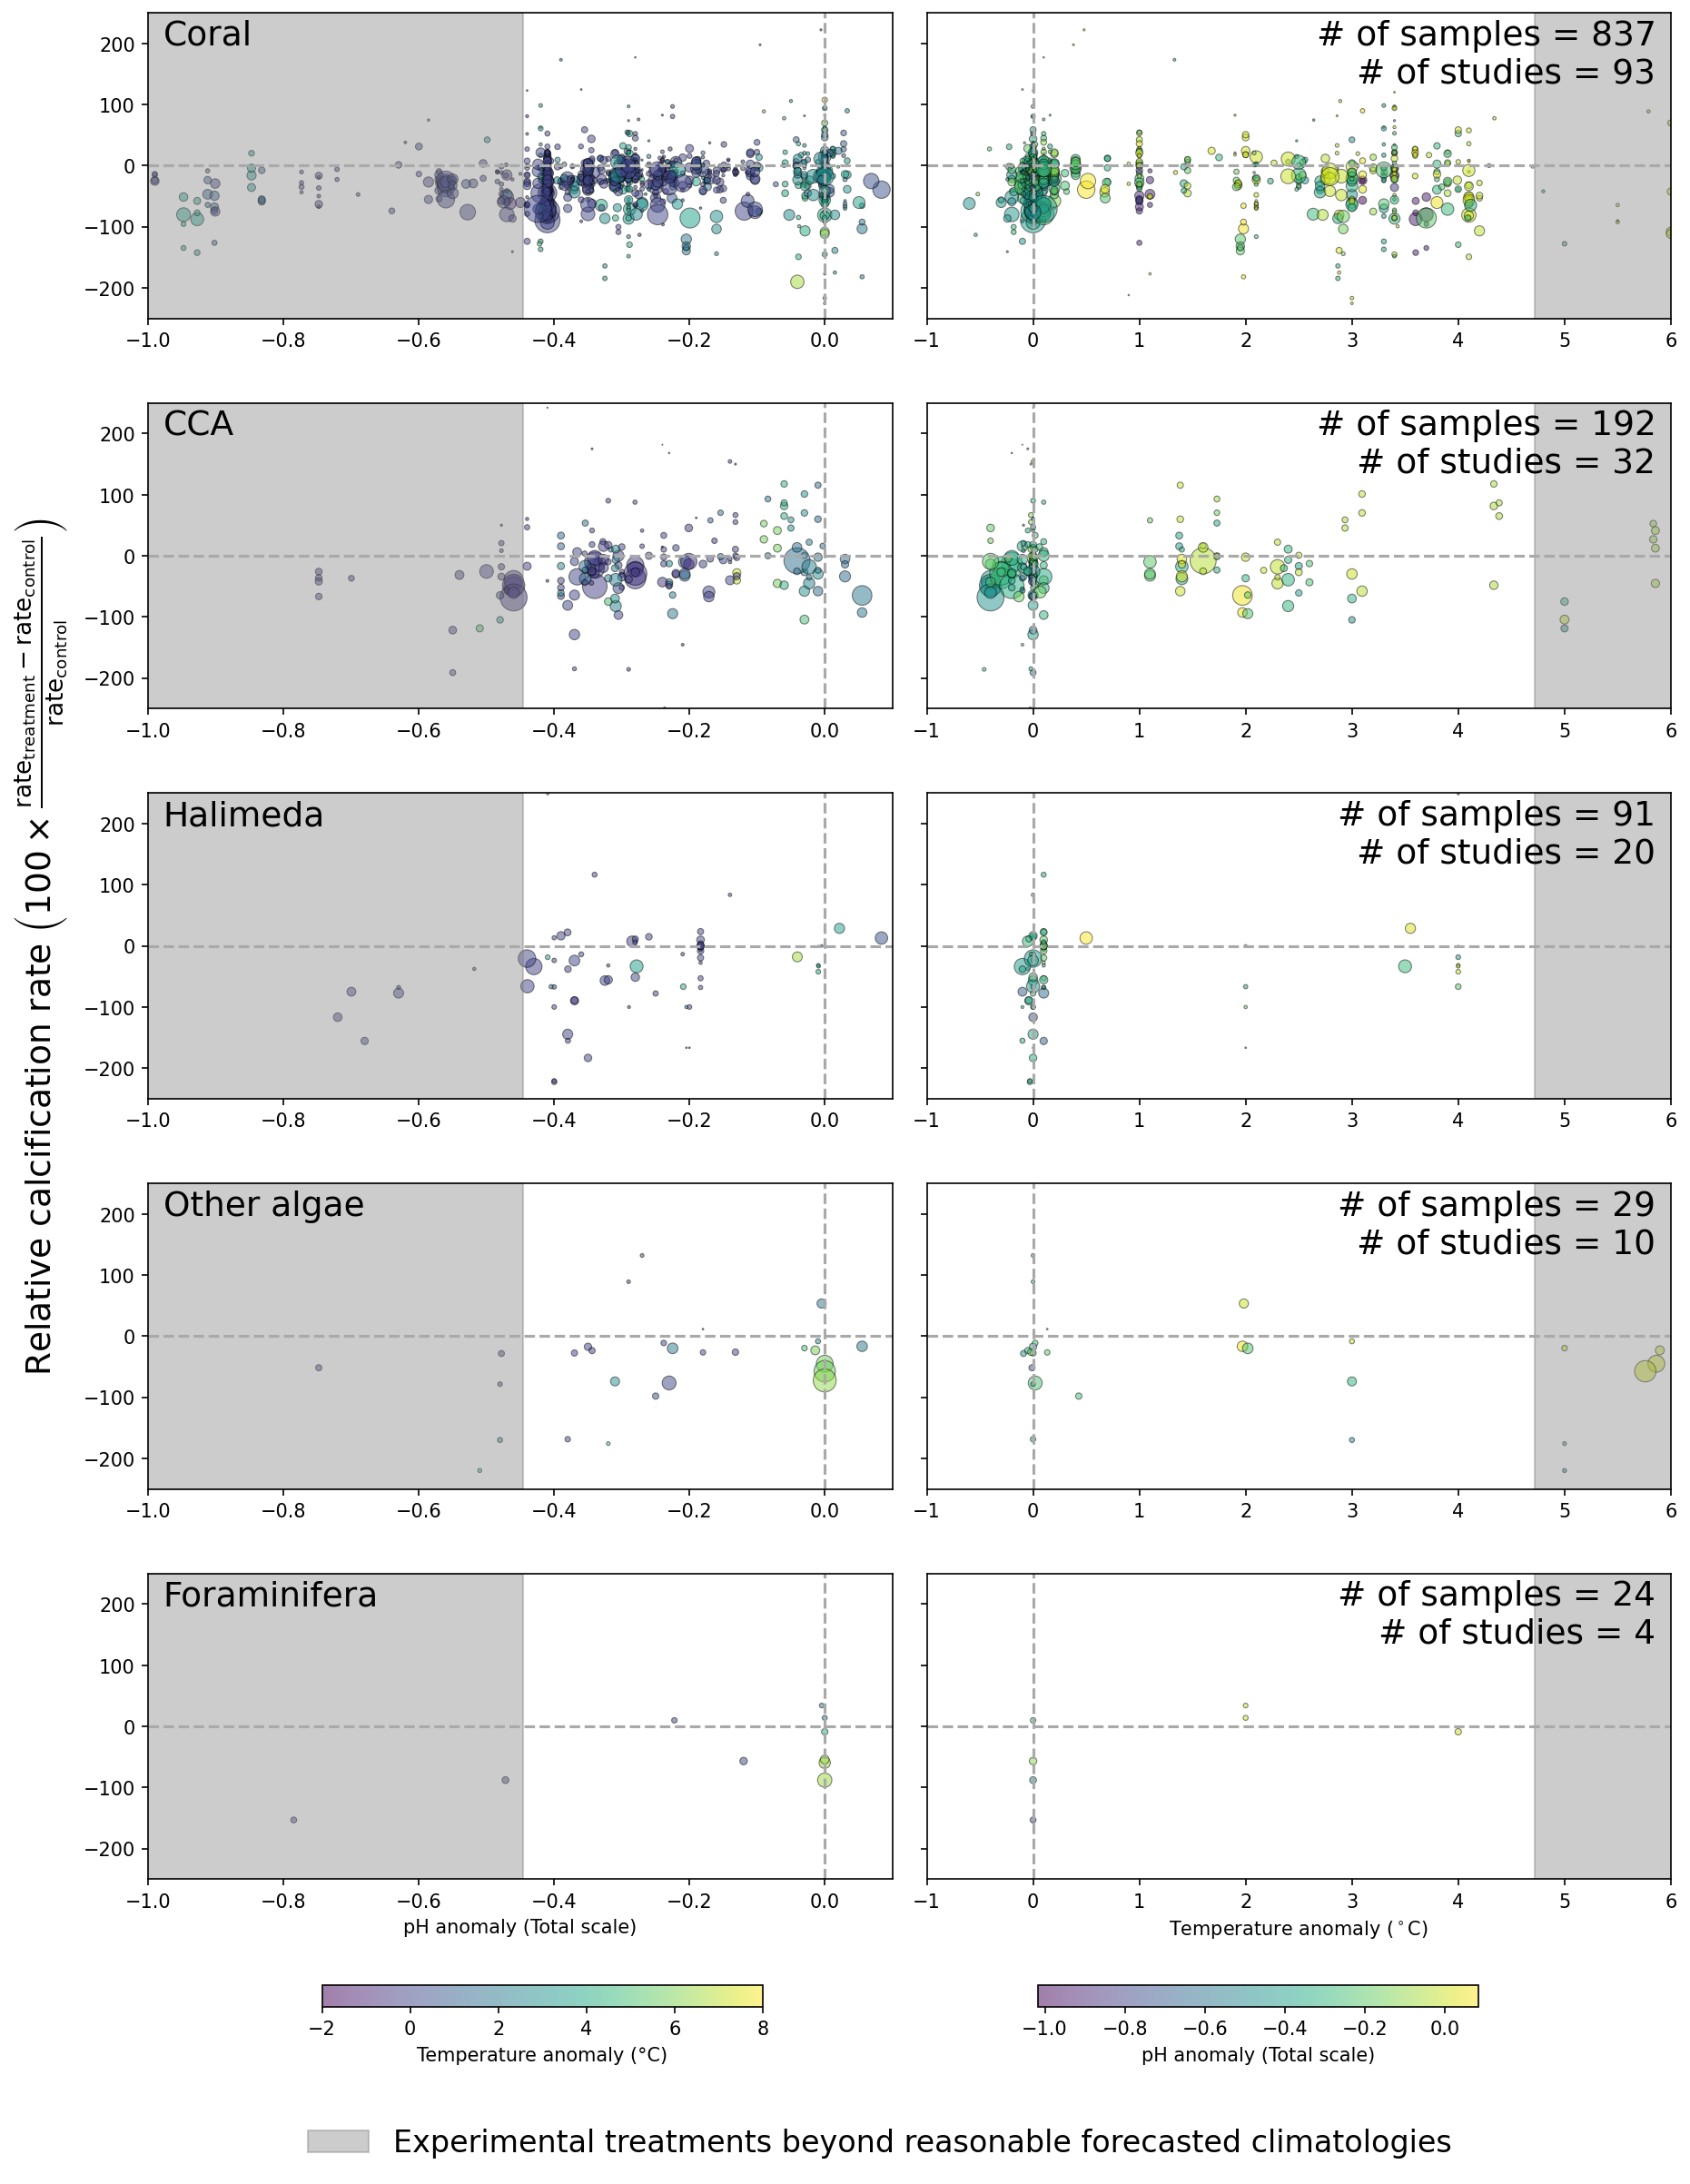

In [11]:
fig, axes = data_exploration.plot_core_grouping_scatter(
    calcification_data_df, global_anomaly_df
)


### Figure S2 – Effect of limiting treatment conditions on model fit

This analysis was run natively in R: see `line 76` of `calcification_meta_analysis/analysis/rnative/analysis.R`

### Figure S3 – Distribution of effect sizes

The Foraminifera category showed significant variation in coefficient estimation when fitting with all data points versus the climatologically filtered data. This was due to the small initial and post-filtering sample sizes and a single study dominating the Foraminifera data (62.5% of data points) which reported exceedingly large changes in calcification rate (mean change of –490% (2 s.f.)). The Foraminifera category was therefore excluded from further analysis.

In [12]:
# exclude Foraminifera from further analysis
calcification_clim_filtered_data_df = calcification_clim_filtered_data_df[
    calcification_clim_filtered_data_df["core_grouping"] != "Foraminifera"
]

/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/NREE_persistence_reef_structures_meta_analysis/calcification_meta_analysis/plotting/data_exploration.py:591: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


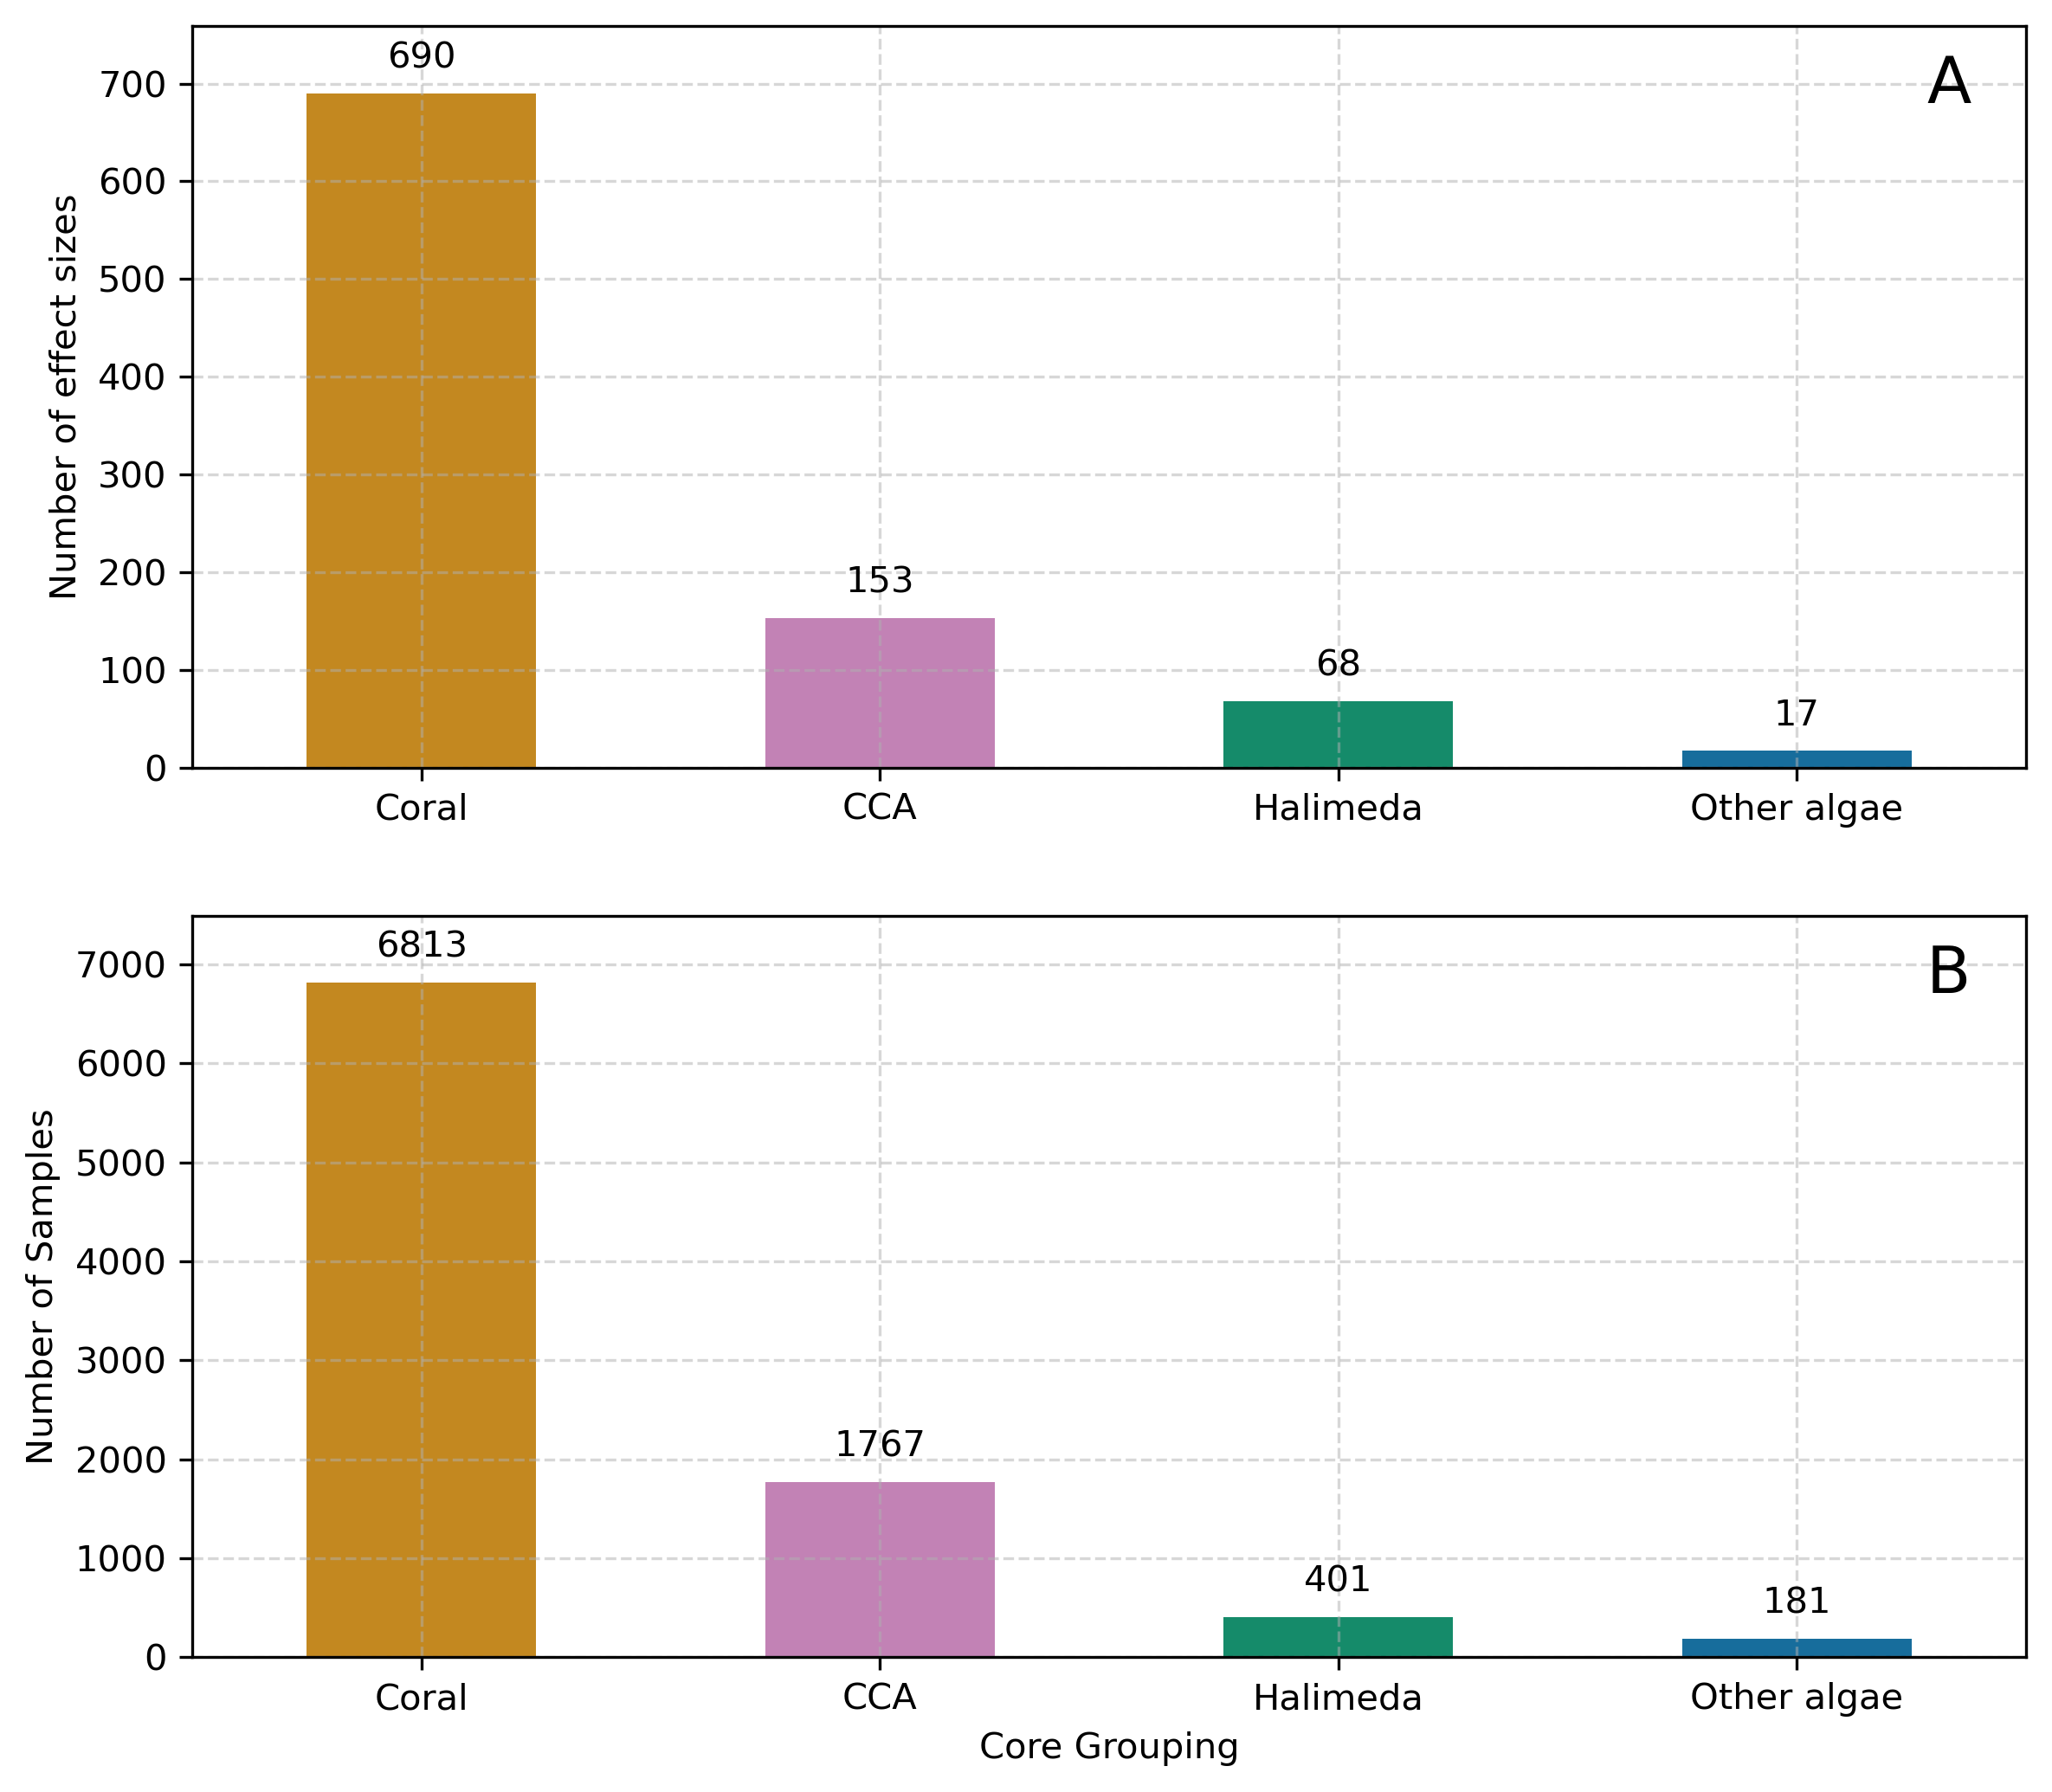

In [13]:
data_exploration.plot_effect_sizes_summary(calcification_clim_filtered_data_df)

### Figure S4 – Distribution of effect sizes

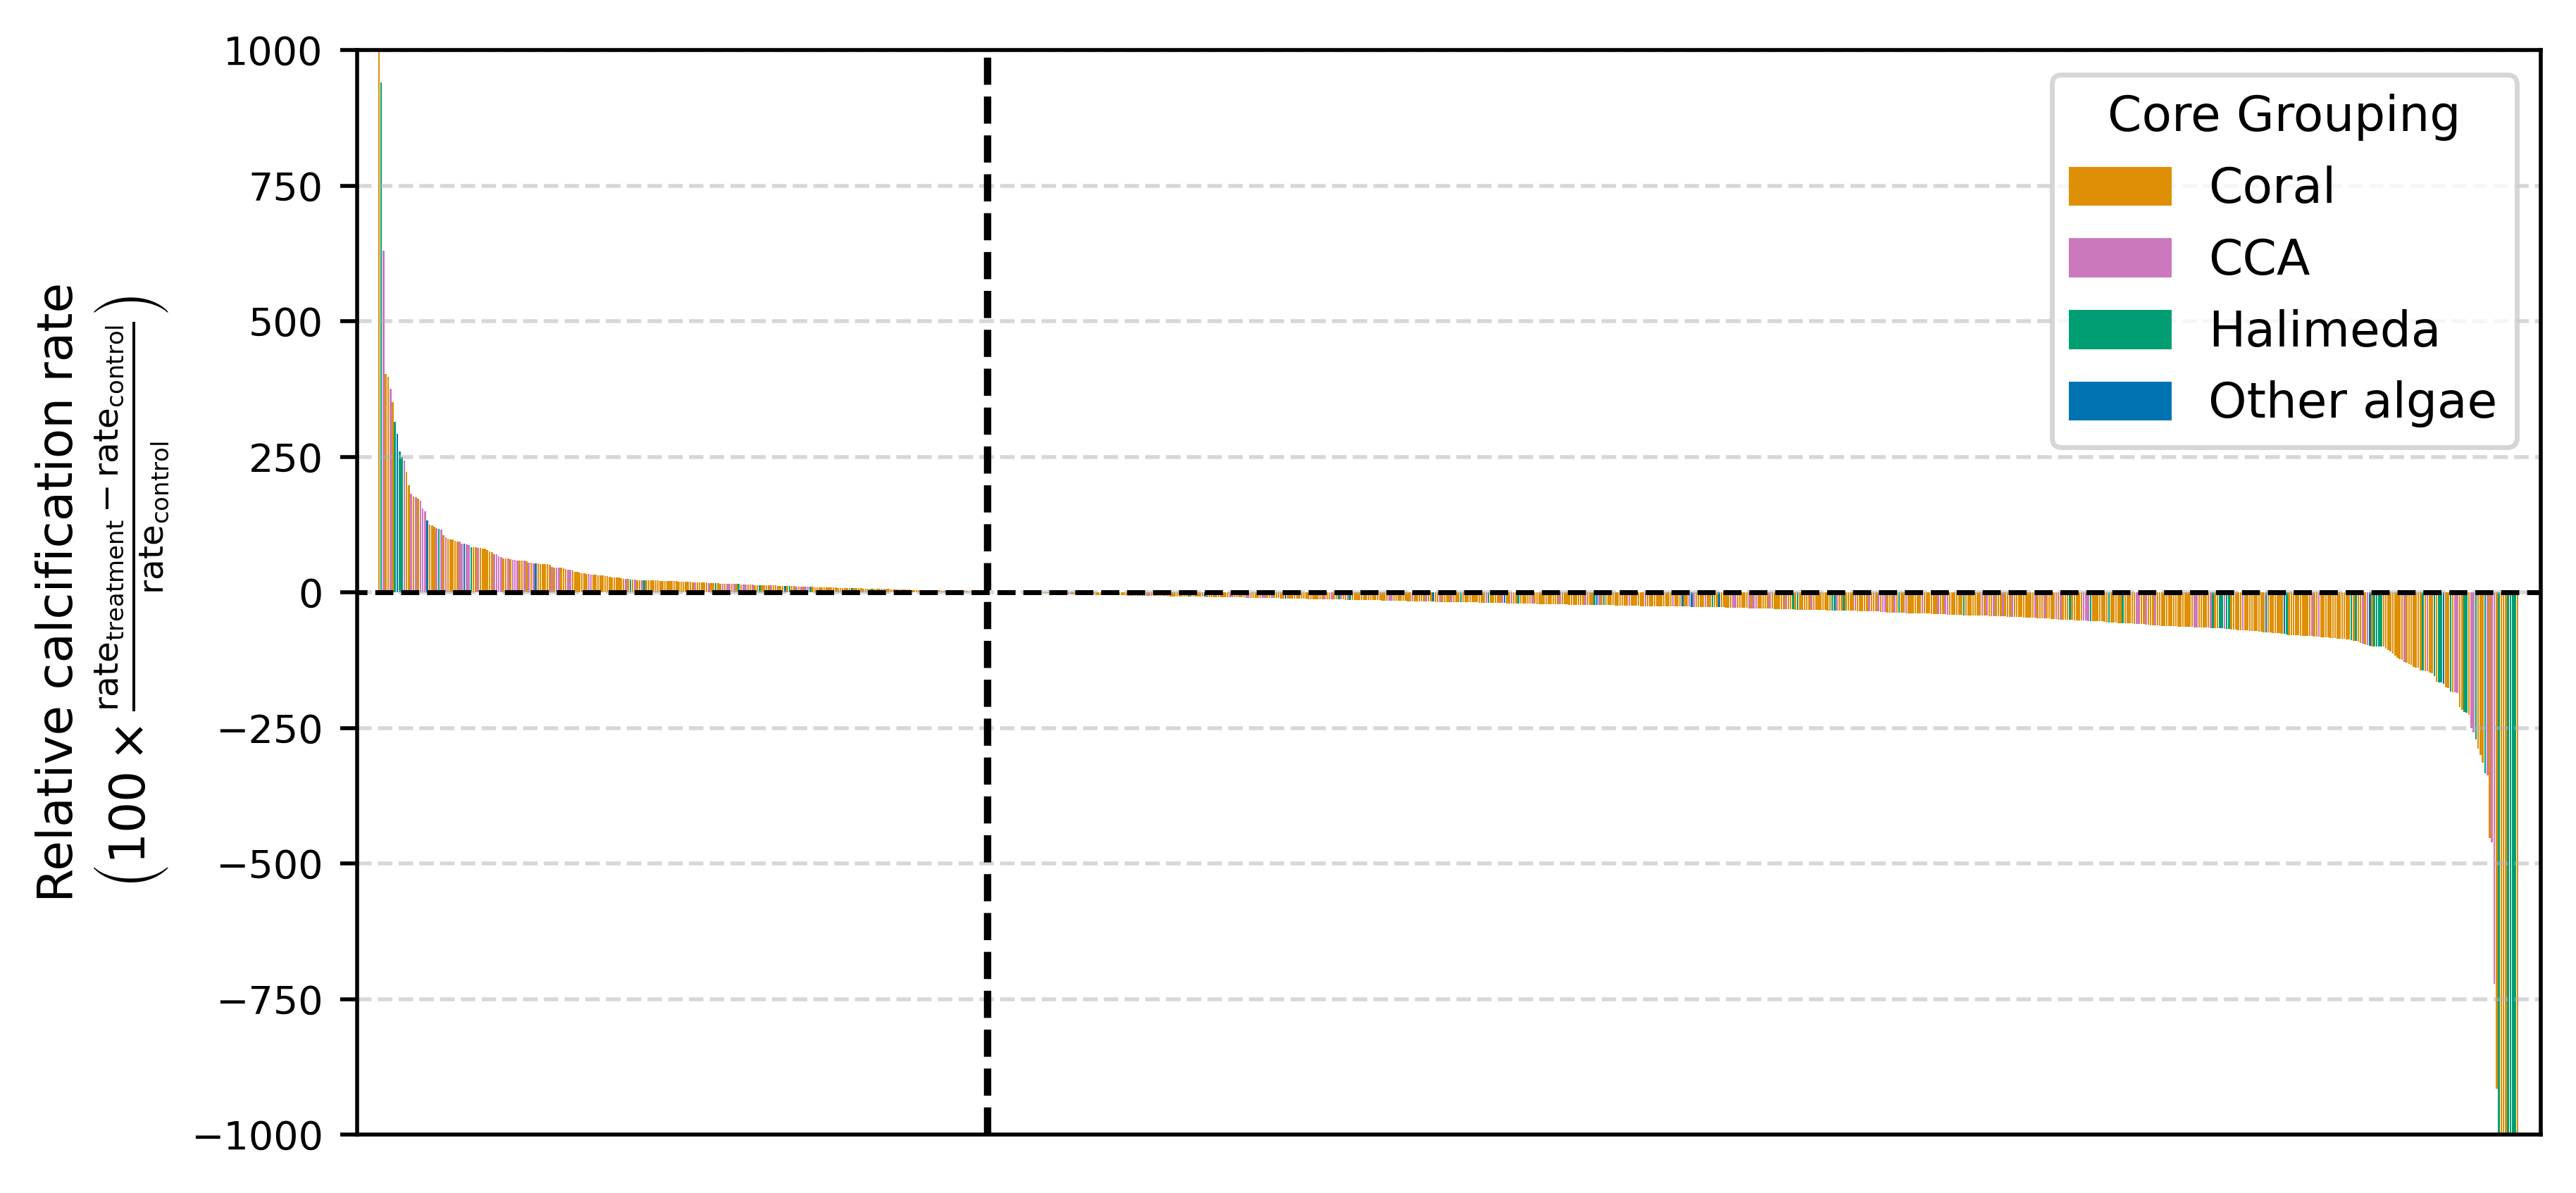

In [14]:
fig, ax = data_exploration.plot_ordered_effect_size_bar(
    calcification_clim_filtered_data_df
)

### Figure S5 – Distributions of effect sizes

/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/NREE_persistence_reef_structures_meta_analysis/calcification_meta_analysis/plotting/data_exploration.py:776: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels(["Overall"])
/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/NREE_persistence_reef_structures_meta_analysis/calcification_meta_analysis/plotting/data_exploration.py:881: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_yticklabels(


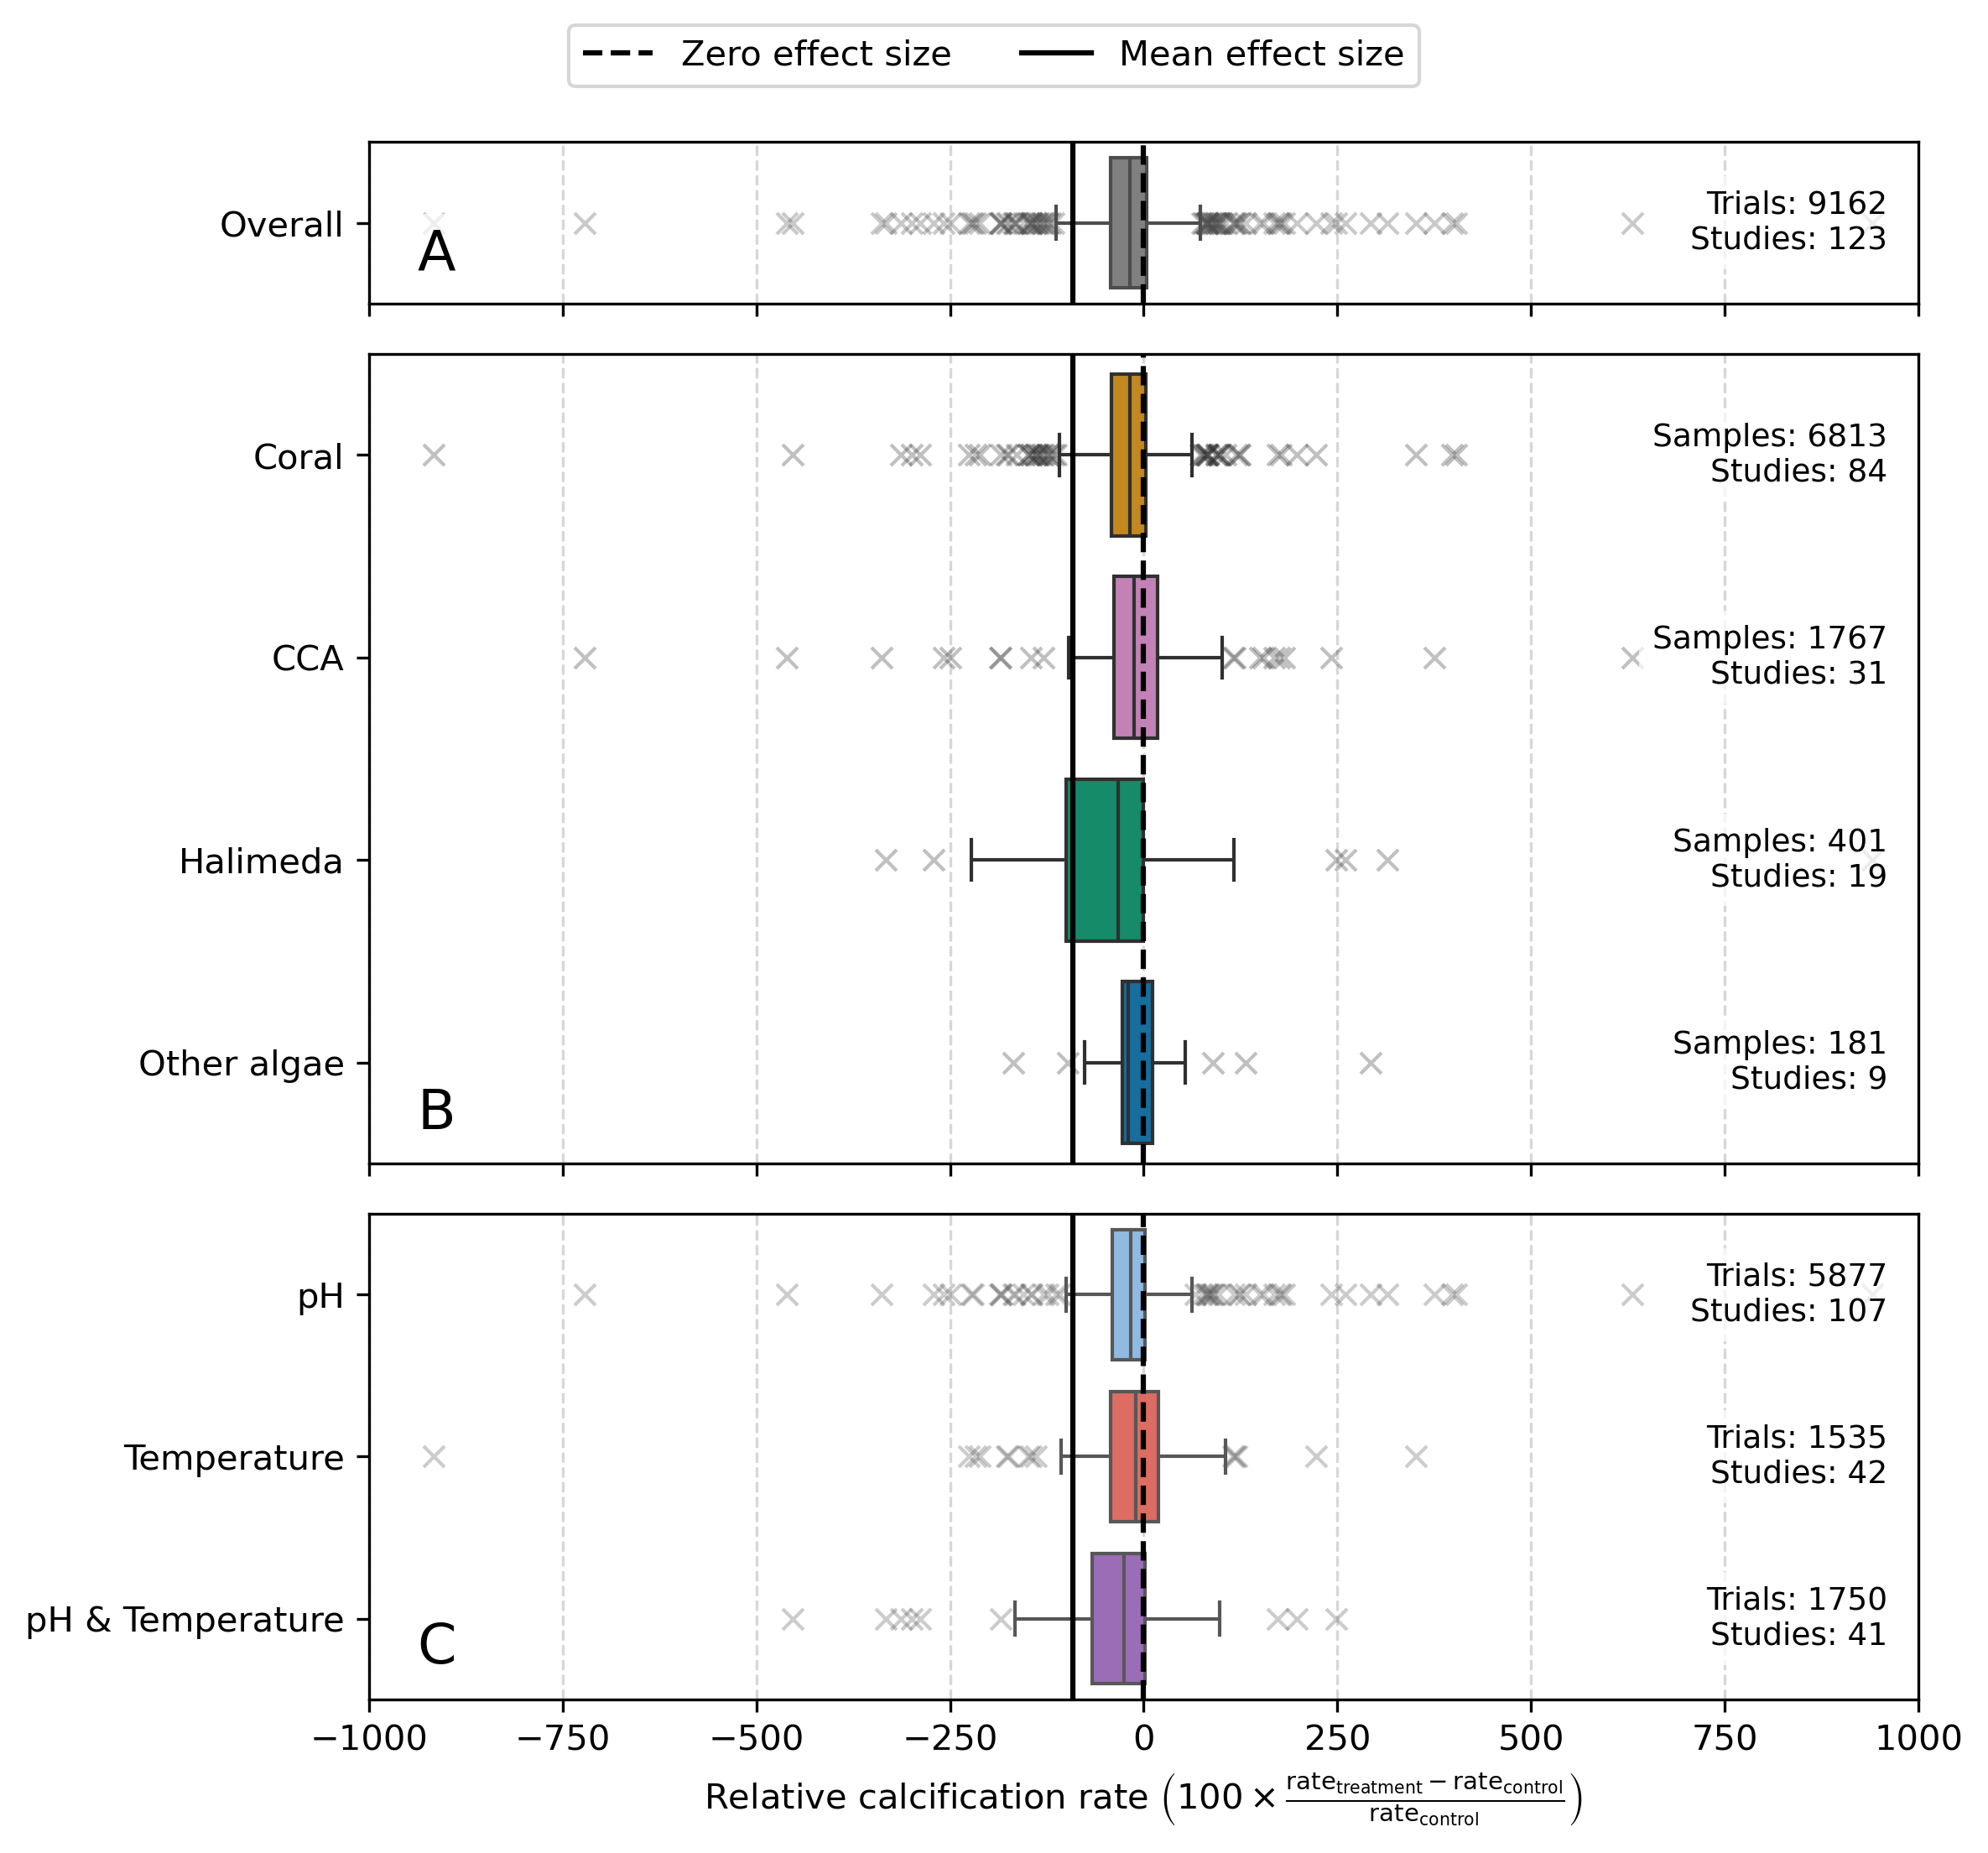

In [15]:
fig, axes = data_exploration.plot_boxplots_by_groupings(
    calcification_clim_filtered_data_df
)

## Sensitivity Analyses

### Figure S6 – Sensitivity analysis of extreme effect sizes (by magnitude, variance)

This analysis was run natively in R: see `line 84` of `calcification_meta_analysis/analysis/rnative/analysis.R`

### Figure S7 – Sensitivity analysis of extreme effect sizes (by Cook's distance)

This analysis was run natively in R: see `line 90` of `calcification_meta_analysis/analysis/rnative/analysis.R`

## Publication bias

### Figure S8 – Assessing publication bias via statistical tests and a funnel plot

This analysis was run natively in R: see `line 96` of `calcification_meta_analysis/analysis/rnative/analysis.R`

## Results

In [16]:
# linear additive model
metafor_model = metafor.MetaforModel(
    calcification_clim_filtered_data_df,
    effect_type=EFFECT_TYPE,
    treatment=["phtot", "temp", "temp_phtot"],
    formula=f"{EFFECT_TYPE} ~ delta_ph + delta_t - 1",
).fit_model()

# display model results
metafor_model.view_model_summary()


INFO:calcification_meta_analysis.analysis.metafor:R DataFrame created with 928 rows
INFO:calcification_meta_analysis.analysis.metafor:Metafor initialized successfully
INFO:calcification_meta_analysis.analysis.metafor:Formula: st_relative_calcification ~ delta_ph + delta_t - 1
INFO:calcification_meta_analysis.analysis.metafor:Treatment: ['phtot', 'temp', 'temp_phtot']
INFO:calcification_meta_analysis.analysis.metafor:Data shape: (928, 126)
INFO:calcification_meta_analysis.analysis.metafor:Fitting model with formula: st_relative_calcification ~ delta_ph + delta_t - 1



----- PROCESSING SUMMARY -----
Treatment:  ['phtot', 'temp', 'temp_phtot']
Total samples in input data:  928
Total samples of relevant investigation:  928
Total samples dropped due to Cook's distance:  0
Dropped due to NaN values:  0
Dropped due to Cook's distance:  0
Final sample count: 928 (0 rows dropped)



  
  
  
  
INFO:calcification_meta_analysis.analysis.metafor:Extracted model components: ['method', 'k', 'QE', 'QEp', 'QM', 'QMp', 'pval', 'beta', 'se', 'zval', 'ci.lb', 'ci.ub', 'fit.stats', 'sigma2.1', 'sigma2.2', 'sigma2']
INFO:calcification_meta_analysis.analysis.metafor:Model fitted successfully
INFO:calcification_meta_analysis.analysis.metafor:Components extracted: ['method', 'k', 'QE', 'QEp', 'QM', 'QMp', 'pval', 'beta', 'se', 'zval', 'ci.lb', 'ci.ub', 'fit.stats', 'sigma2.1', 'sigma2.2', 'sigma2']



Multivariate Meta-Analysis Model (k = 928; method: REML)

    logLik    Deviance         AIC         BIC        AICc   
-4918.3643   9836.7287   9844.7287   9864.0522   9844.7721   

Variance Components:

              estim     sqrt  nlvls  fixed  factor 
sigma^2.1  539.0681  23.2178    142     no     doi 
sigma^2.2  777.6429  27.8862    928     no  doi/ID 

Test for Residual Heterogeneity:
QE(df = 926) = 15021.4483, p-val < .0001

Test of Moderators (coefficients 1:2):
QM(df = 2) = 108.3091, p-val < .0001

Model Results:

          estimate      se     zval    pval    ci.lb    ci.ub      
delta_ph   65.7325  7.6399   8.6038  <.0001  50.7585  80.7064  *** 
delta_t    -6.1409  1.0756  -5.7093  <.0001  -8.2490  -4.0328  *** 

---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




###  Testing random effect structure

In [17]:
print("Fitting model with ~ 1| DOI random effect structure...")
doi_model = metafor.MetaforModel(
    calcification_clim_filtered_data_df,
    effect_type=EFFECT_TYPE,
    formula=f"{EFFECT_TYPE} ~ delta_ph + delta_t - 1",
    random="~ 1 | doi",
    verbose=False,
).fit_model()
print("\nFitting model with ~ 1| DOI/ID random effect structure...")
doi_id_model = metafor.MetaforModel(
    calcification_clim_filtered_data_df,
    effect_type=EFFECT_TYPE,
    formula=f"{EFFECT_TYPE} ~ delta_ph + delta_t - 1",
    random="~ 1 | doi/ID",
    verbose=False,
).fit_model()

Fitting model with ~ 1| DOI random effect structure...



Fitting model with ~ 1| DOI/ID random effect structure...


In [18]:
print("~1 | DOI random effect structure:")
print(doi_model.generate_model_fit_dataframe())
print("\n~1 | DOI/ID random effect structure:")
print(doi_id_model.generate_model_fit_dataframe())

~1 | DOI random effect structure:
     k      LogLik     Deviance          AIC          AICc           BIC
0  928 -7024.77233  14049.54466  14055.54466  14055.570691  14070.037283

~1 | DOI/ID random effect structure:
     k      LogLik   Deviance        AIC         AICc          BIC
0  928 -4918.36435  9836.7287  9844.7287  9844.772131  9864.052197


### Example predicted response surface

INFO:calcification_meta_analysis.analysis.metafor:R DataFrame created with 690 rows
INFO:calcification_meta_analysis.analysis.metafor:Metafor initialized successfully
INFO:calcification_meta_analysis.analysis.metafor:Formula: st_relative_calcification ~ delta_ph + delta_t - 1
INFO:calcification_meta_analysis.analysis.metafor:Treatment: ['phtot', 'temp', 'temp_phtot']
INFO:calcification_meta_analysis.analysis.metafor:Data shape: (690, 126)
INFO:calcification_meta_analysis.analysis.metafor:Fitting model with formula: st_relative_calcification ~ delta_ph + delta_t - 1



----- PROCESSING SUMMARY -----
Treatment:  ['phtot', 'temp', 'temp_phtot']
Total samples in input data:  690
Total samples of relevant investigation:  690
Total samples dropped due to Cook's distance:  0
Dropped due to NaN values:  0
Dropped due to Cook's distance:  0
Final sample count: 690 (0 rows dropped)



  
  
  
INFO:calcification_meta_analysis.analysis.metafor:Extracted model components: ['method', 'k', 'QE', 'QEp', 'QM', 'QMp', 'pval', 'beta', 'se', 'zval', 'ci.lb', 'ci.ub', 'fit.stats', 'sigma2.1', 'sigma2.2', 'sigma2']
INFO:calcification_meta_analysis.analysis.metafor:Model fitted successfully
INFO:calcification_meta_analysis.analysis.metafor:Components extracted: ['method', 'k', 'QE', 'QEp', 'QM', 'QMp', 'pval', 'beta', 'se', 'zval', 'ci.lb', 'ci.ub', 'fit.stats', 'sigma2.1', 'sigma2.2', 'sigma2']


(<Figure size 1000x800 with 2 Axes>,
 <Axes: xlabel='delta_ph', ylabel='delta_t'>)

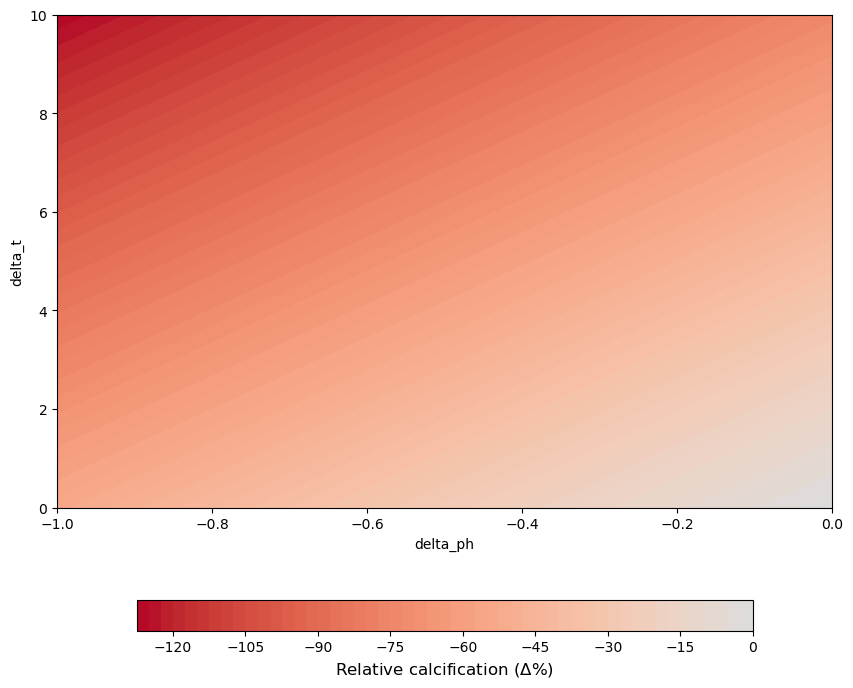

In [19]:
# select example core grouping
coral_model = metafor.MetaforModel(
    calcification_clim_filtered_data_df[
        calcification_clim_filtered_data_df["core_grouping"] == "Coral"
    ],
    effect_type=EFFECT_TYPE,
    treatment=["phtot", "temp", "temp_phtot"],
    formula=f"{EFFECT_TYPE} ~ delta_ph + delta_t - 1",
).fit_model()

analysis_plot.plot_model_surface_2d(
    model=coral_model,
    moderator_names=["delta_ph", "delta_t"],
    prediction_limits={"delta_ph": (-1, 0), "delta_t": (0, 10)},
)


### Generating future predictions

Using forecasted global climatology anomalies to sample from predicted response surfaces. 



In [20]:
# --- process bioerosion data --- #
extracted_bioerosion_data_fp = config.data_dir / "Orlando_data.xlsx"
# extracted_bioerosion_data_fp = config.data_dir / "extracted_bioerosion_data.xlsx"
bioerosion_data_df = process.process_extracted_calcification_data(
    extracted_bioerosion_data_fp, "all_bioerosion"
)
bioerosion_data_df["core_grouping"] = "Bioerosion"

INFO:calcification_meta_analysis.processing.locations:Using cached locations in /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/NREE_persistence_reef_structures_meta_analysis/resources/gmaps_locations.yaml
INFO:calcification_meta_analysis.processing.locations:Dropped 0 row(s) for which latitude or longitude is NaN
INFO:calcification_meta_analysis.processing.taxonomy:Using species mapping in /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/NREE_persistence_reef_structures_meta_analysis/resources/species_mapping.yaml
INFO:calcification_meta_analysis.processing.cleaning:Unit standardization complete: 83/83 rows converted successfully
INFO:calcification_meta_analysis.processing.carbonate_processing:Loading measured values...
INFO:calcification_meta_analysis.processing.carbonate_processing:Calculated 15 missing phtot values using pHnbs/pHsws
INFO:calcification_meta_analysis.processing.carbonate_

Calculating carbonate chemistry:   0%|          | 0/83 [00:00<?, ?it/s]

INFO:calcification_meta_analysis.processing.carbonate_processing:Filled 161.0 NaN values by combining dataframes


Assigning treatment groups:   0%|          | 0/18 [00:00<?, ?it/s]

Removing 0 rows with n=1


  0%|          | 0/17 [00:00<?, ?it/s]

Missing data for effect size calculation. n_t: 9.000, n_c: 9.000 at 
[index 80 DOI 10.1029/2008GB003286]Raw: mu_t: 0.460, mu_c: 0.310, sd_t: nan, sd_c: nan, Std: s_mu_t: 0.000, s_mu_c: 0.000, s_sd_t: nan, s_sd_c: nan, 


In [21]:
# reverse sign of effect sizes (cohens_d, hedges_g, relative_calcification, absolute_calcification, st_relative_calcification, st_absolute_calcification) for plotting alongside calcification rates
bioerosion_data_df.loc[:, "cohens_d"] = -bioerosion_data_df["cohens_d"]
bioerosion_data_df.loc[:, "hedges_g"] = -bioerosion_data_df["hedges_g"]
bioerosion_data_df.loc[:, "relative_calcification"] = -bioerosion_data_df[
    "relative_calcification"
]
bioerosion_data_df.loc[:, "absolute_calcification"] = -bioerosion_data_df[
    "absolute_calcification"
]
bioerosion_data_df.loc[:, "st_relative_calcification"] = -bioerosion_data_df[
    "st_relative_calcification"
]
bioerosion_data_df.loc[:, "st_absolute_calcification"] = -bioerosion_data_df[
    "st_absolute_calcification"
]

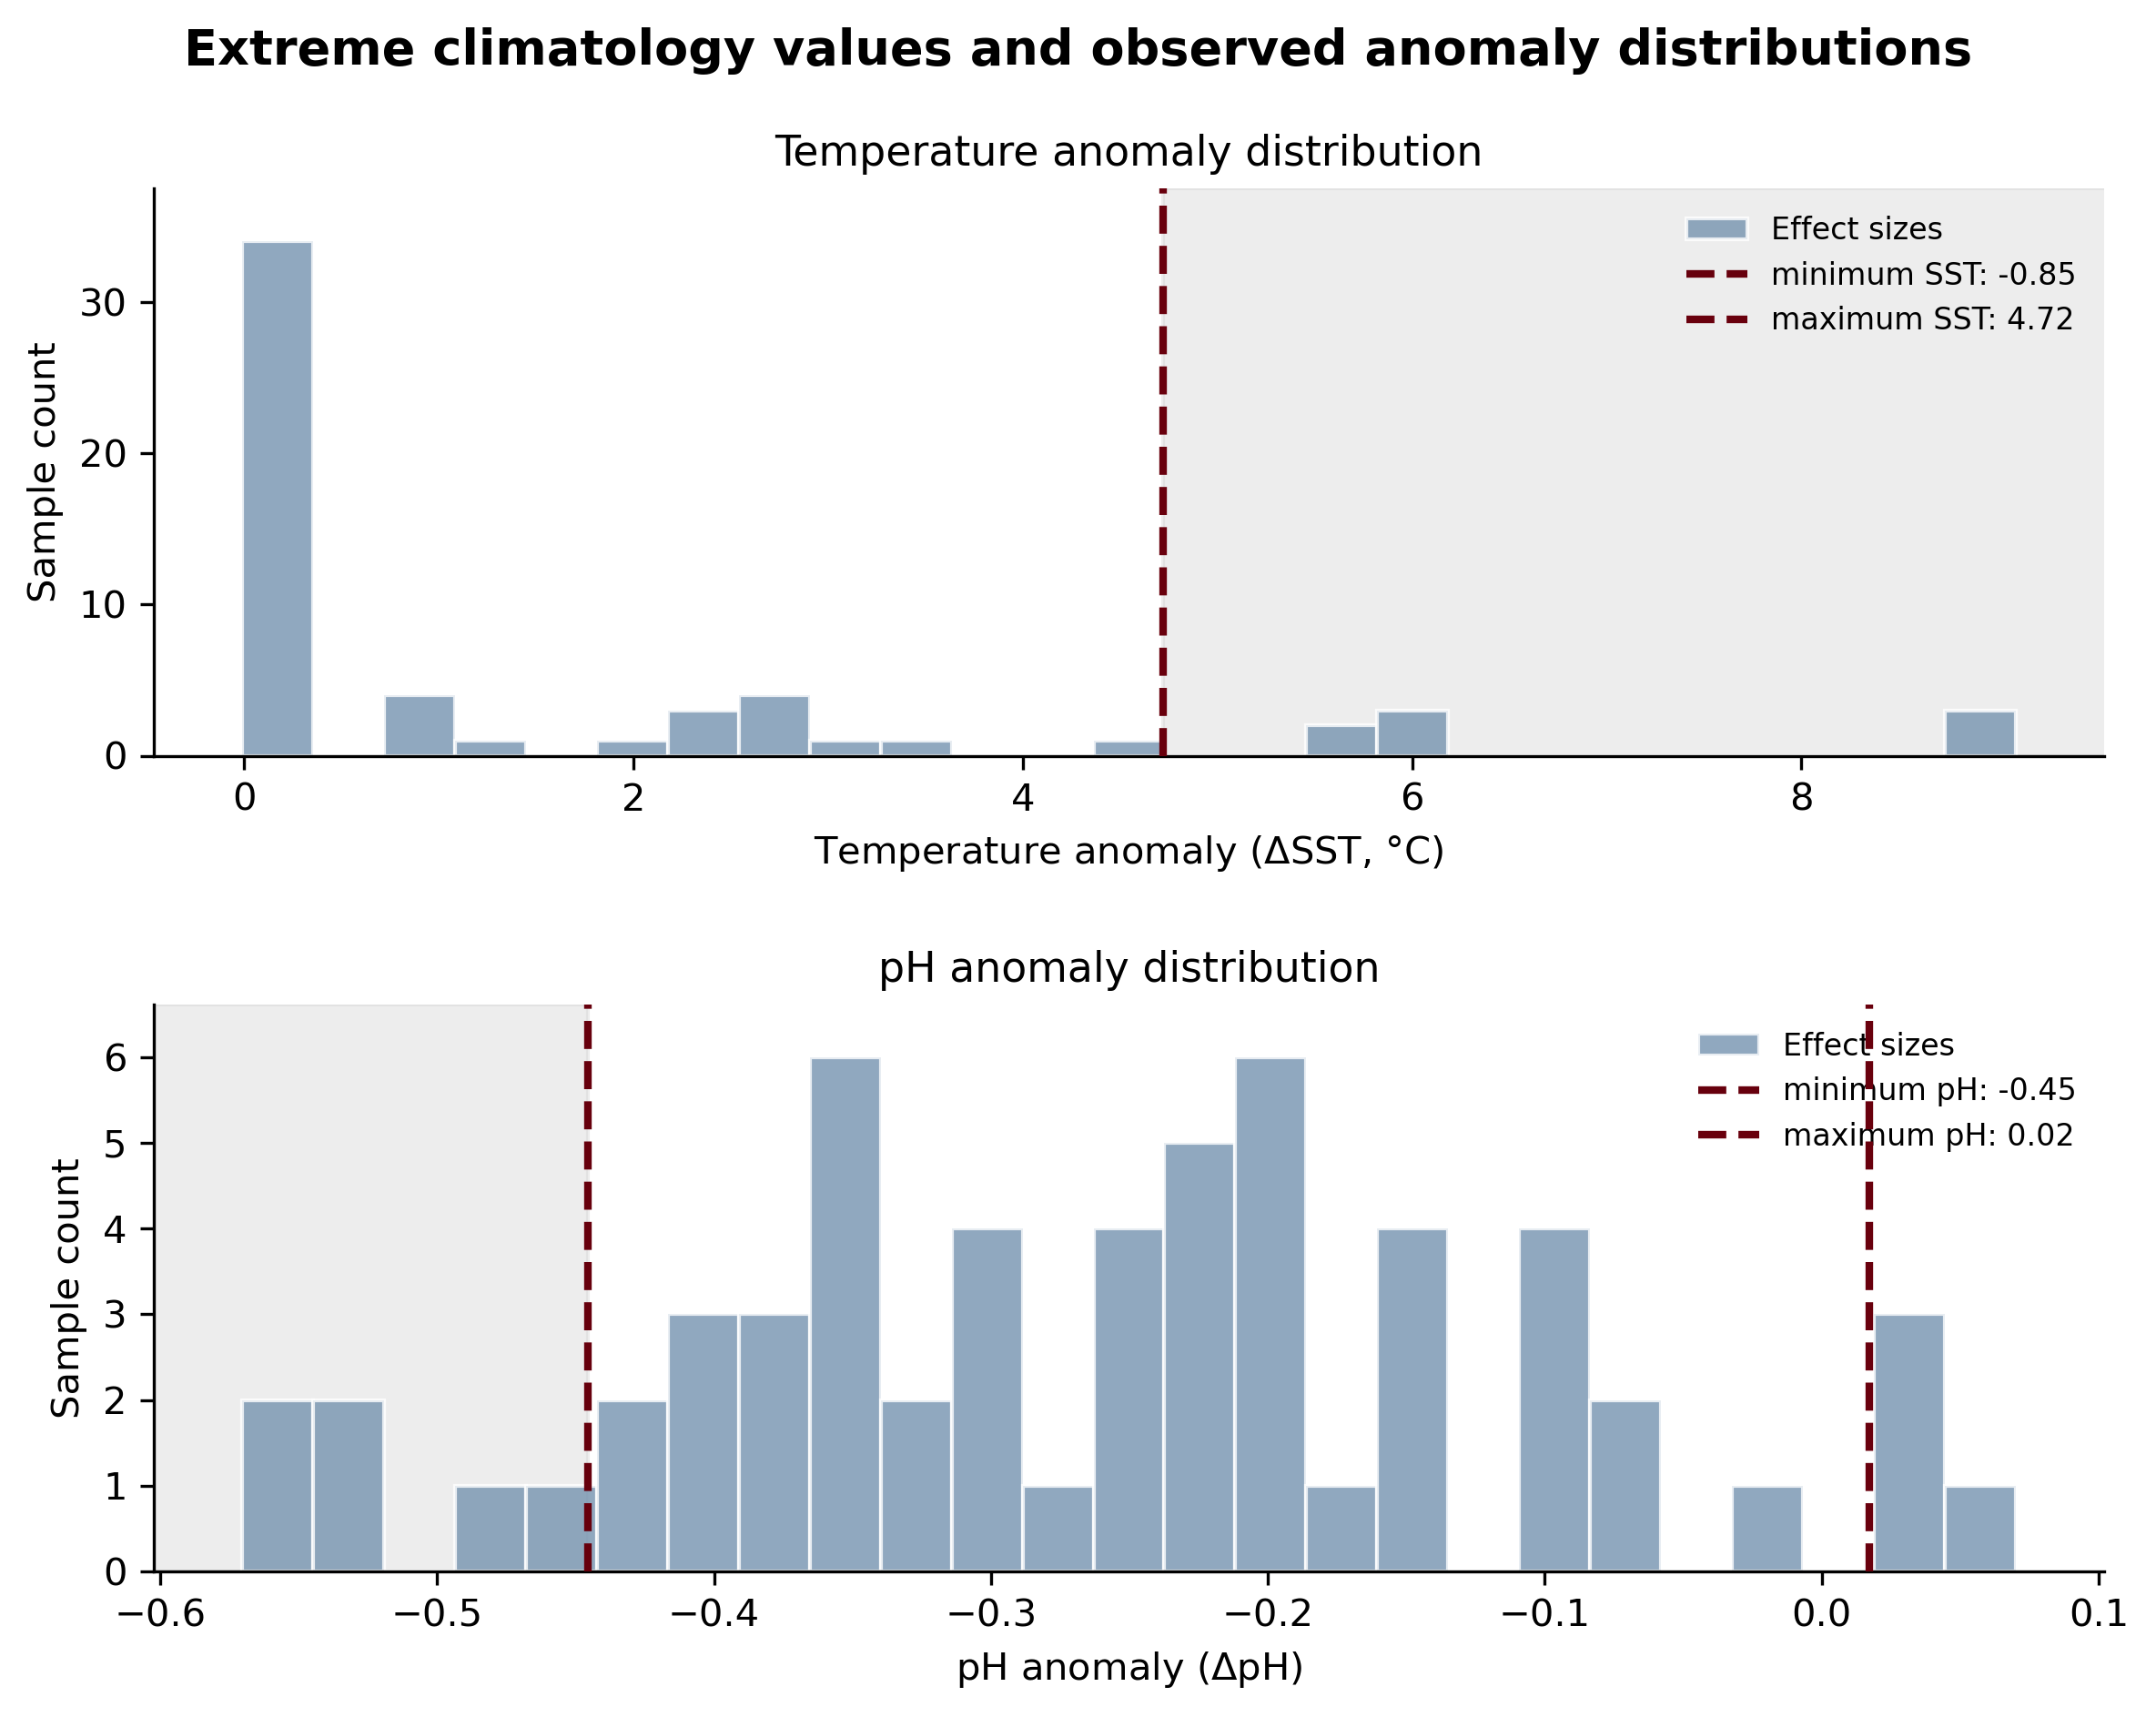

In [22]:
# --- filter to reasonable climatologies --- #
bioerosion_clim_filtered_data_df = climatology.filter_df_by_extreme_climatologies(
    bioerosion_data_df, global_anomaly_df
)
climatology_plot.plot_extreme_climatology_values(bioerosion_data_df, global_anomaly_df);

In [23]:
### calculate the predicted response surfaces for calcification and bioerosion with future climate conditions
combined_df = pd.concat(
    [calcification_clim_filtered_data_df, bioerosion_clim_filtered_data_df]
)

response_df, heterogeneity_df, models_dict = (
    analysis.construct_predicted_response_surfaces(
        combined_df,
        global_anomaly_df,
        EFFECT_TYPE,
    )
)

  0%|          | 0/5 [00:00<?, ?it/s]

### Figure S9 – Projected calcification and bioerosion rates in 2050 and 2100 under the Shared Socioeconomic Pathways (SSPs) relative to the historical baseline (1982-2011)

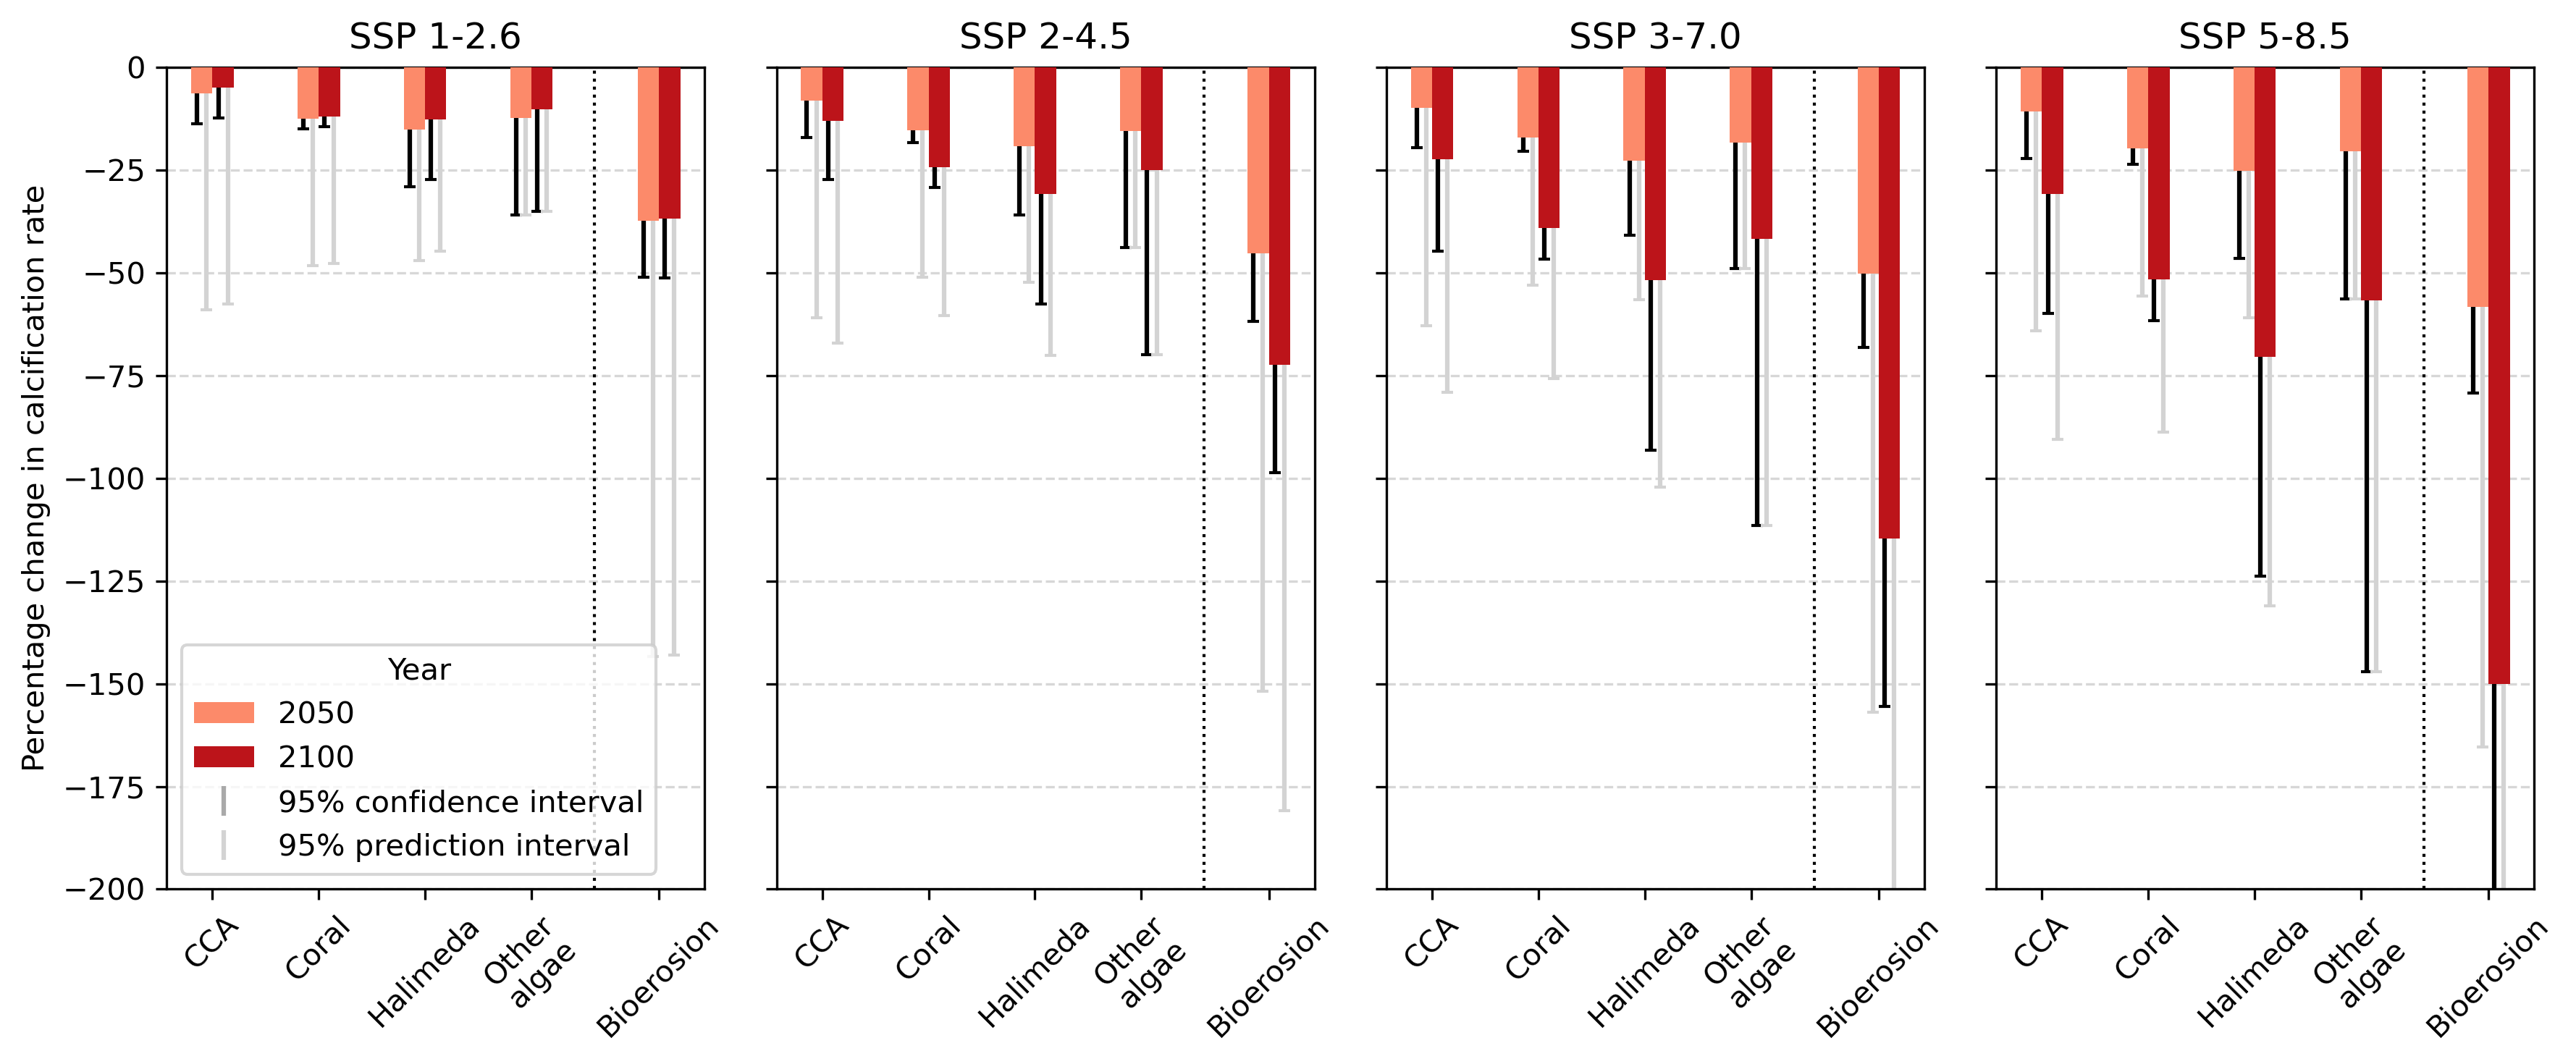

In [24]:
analysis_plot.plot_projected_rates_barplot(response_df)


### Figure S10 – Projected calcification and bioerosion rates relative to the historical baseline (1982-2011) until the end of the century under the Shared Socioeconomic Pathways (SSPs)

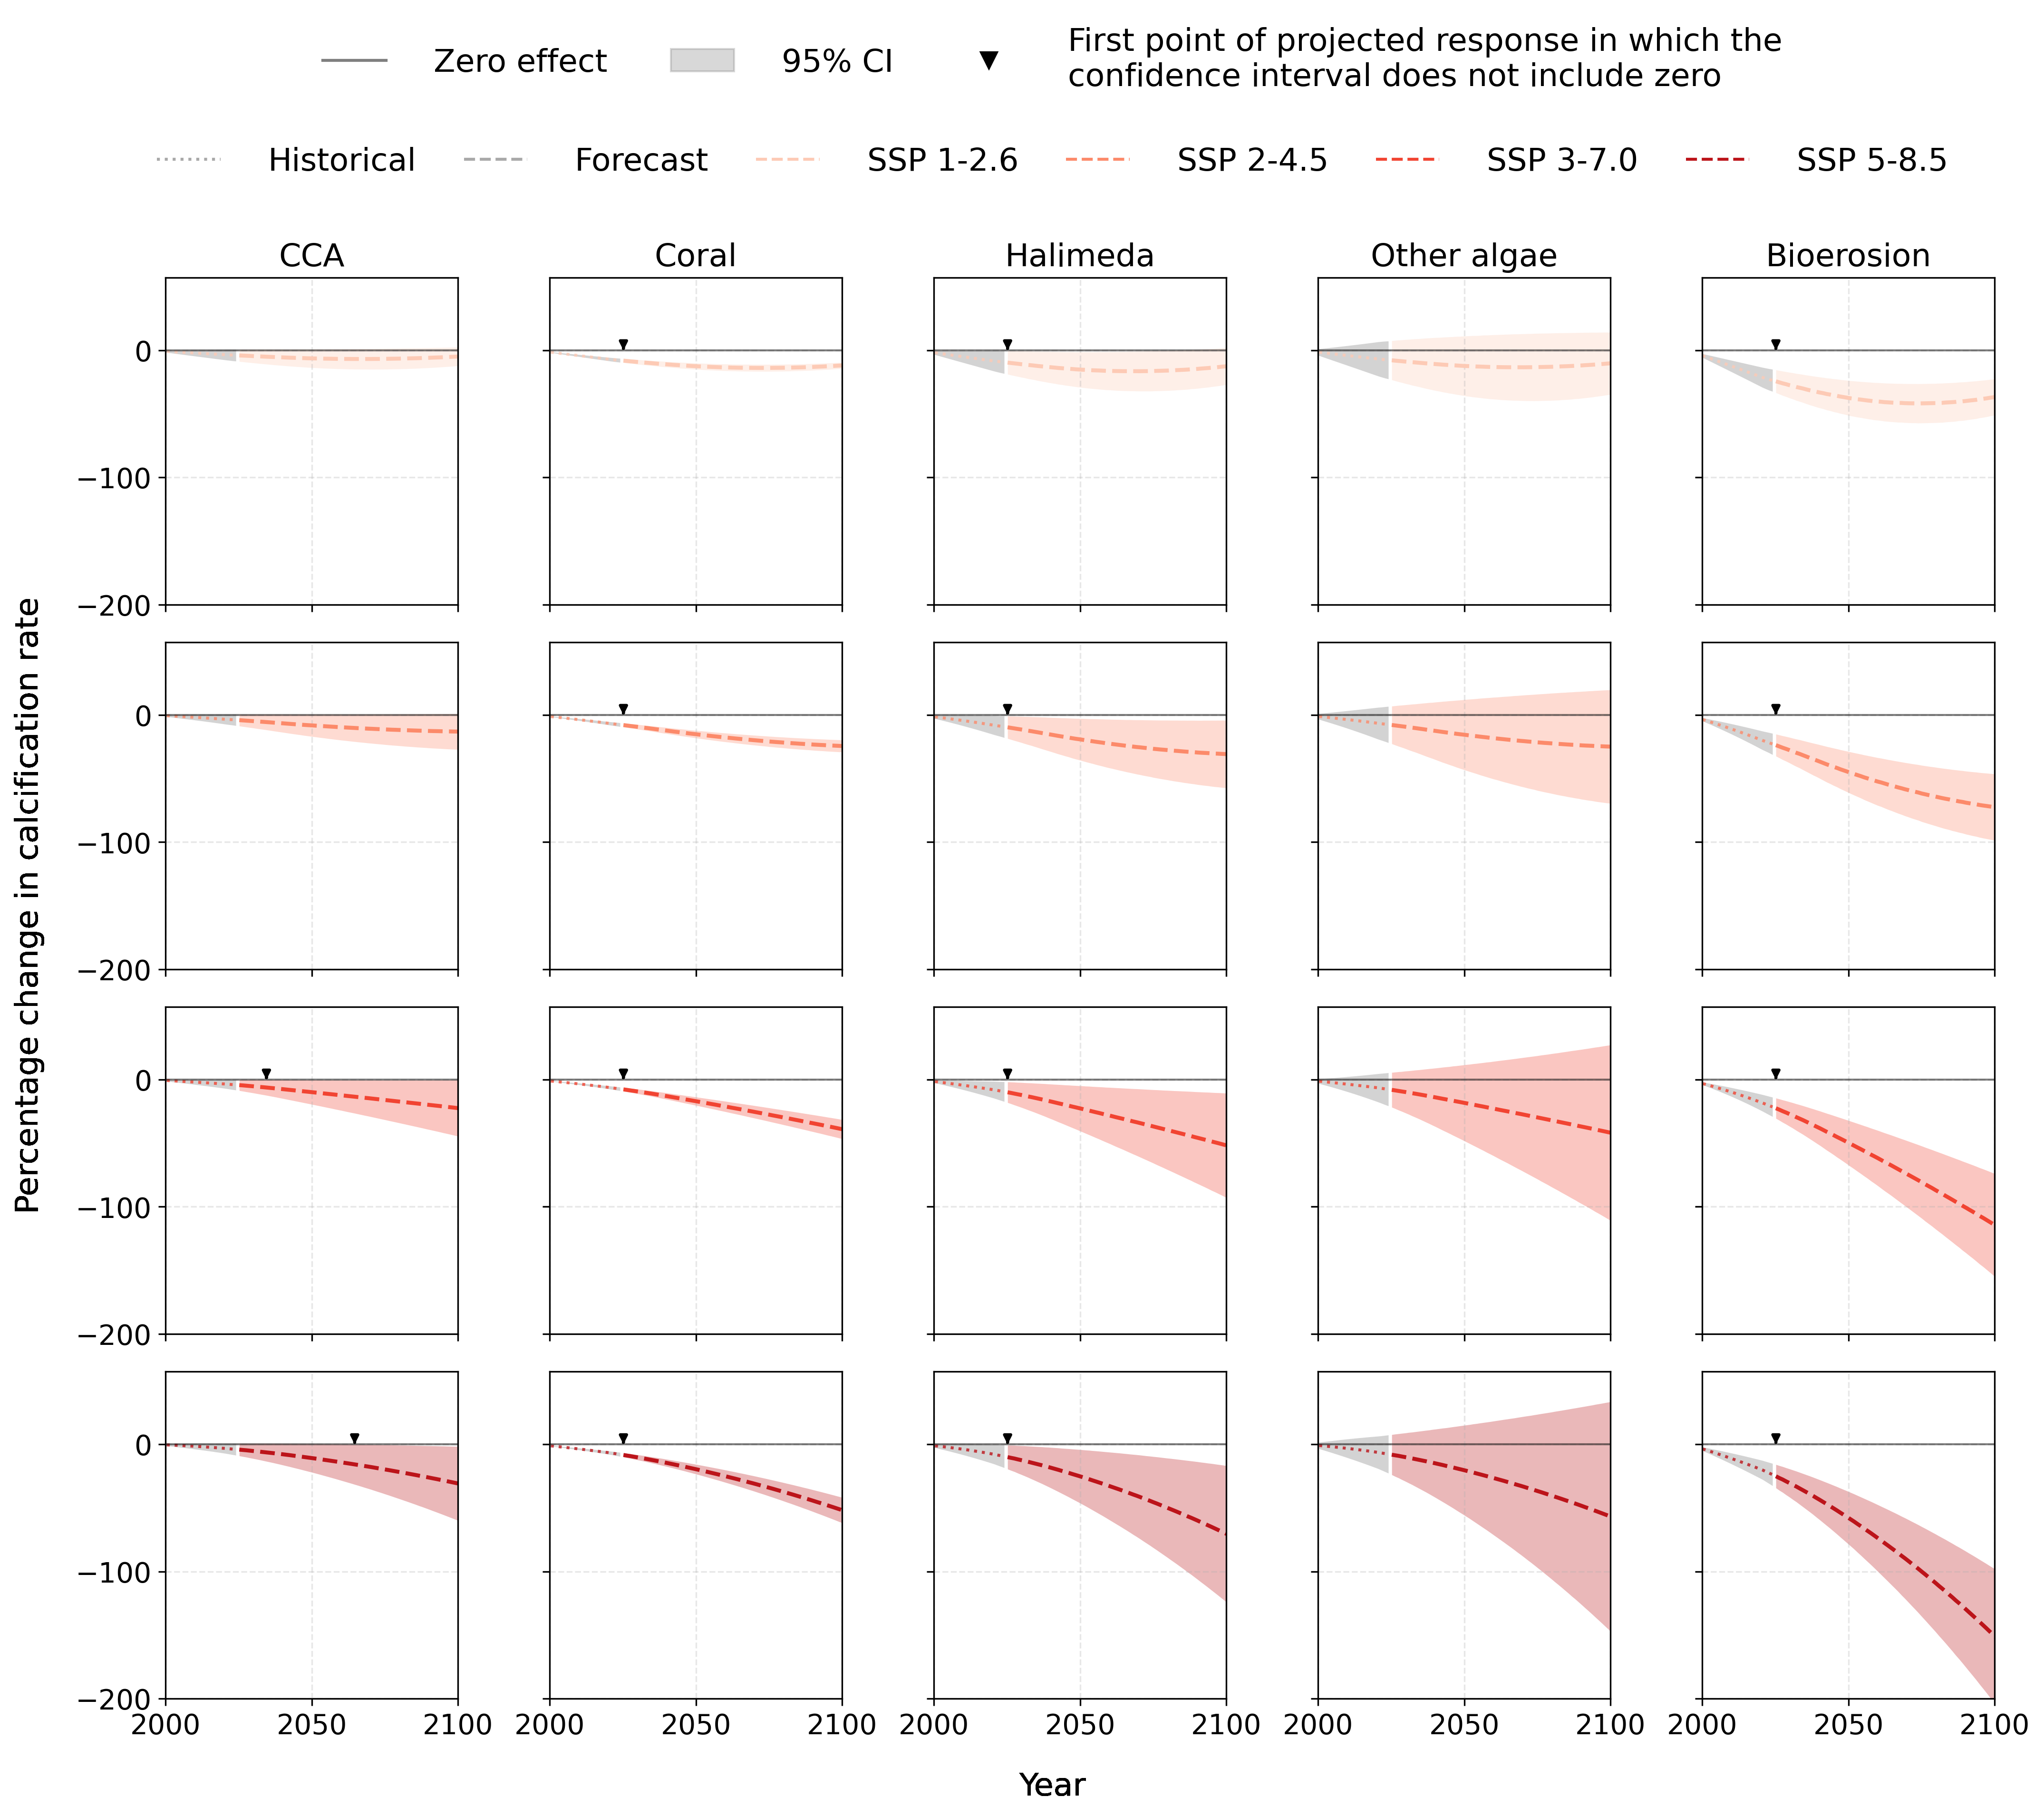

In [25]:
analysis_plot.plot_global_timeseries_grid(response_df, figsize=(14, 12));

## Figure 2 – Class-specific response

/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/NREE_persistence_reef_structures_meta_analysis/calcification_meta_analysis/plotting/analysis.py:2060: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 0.97])


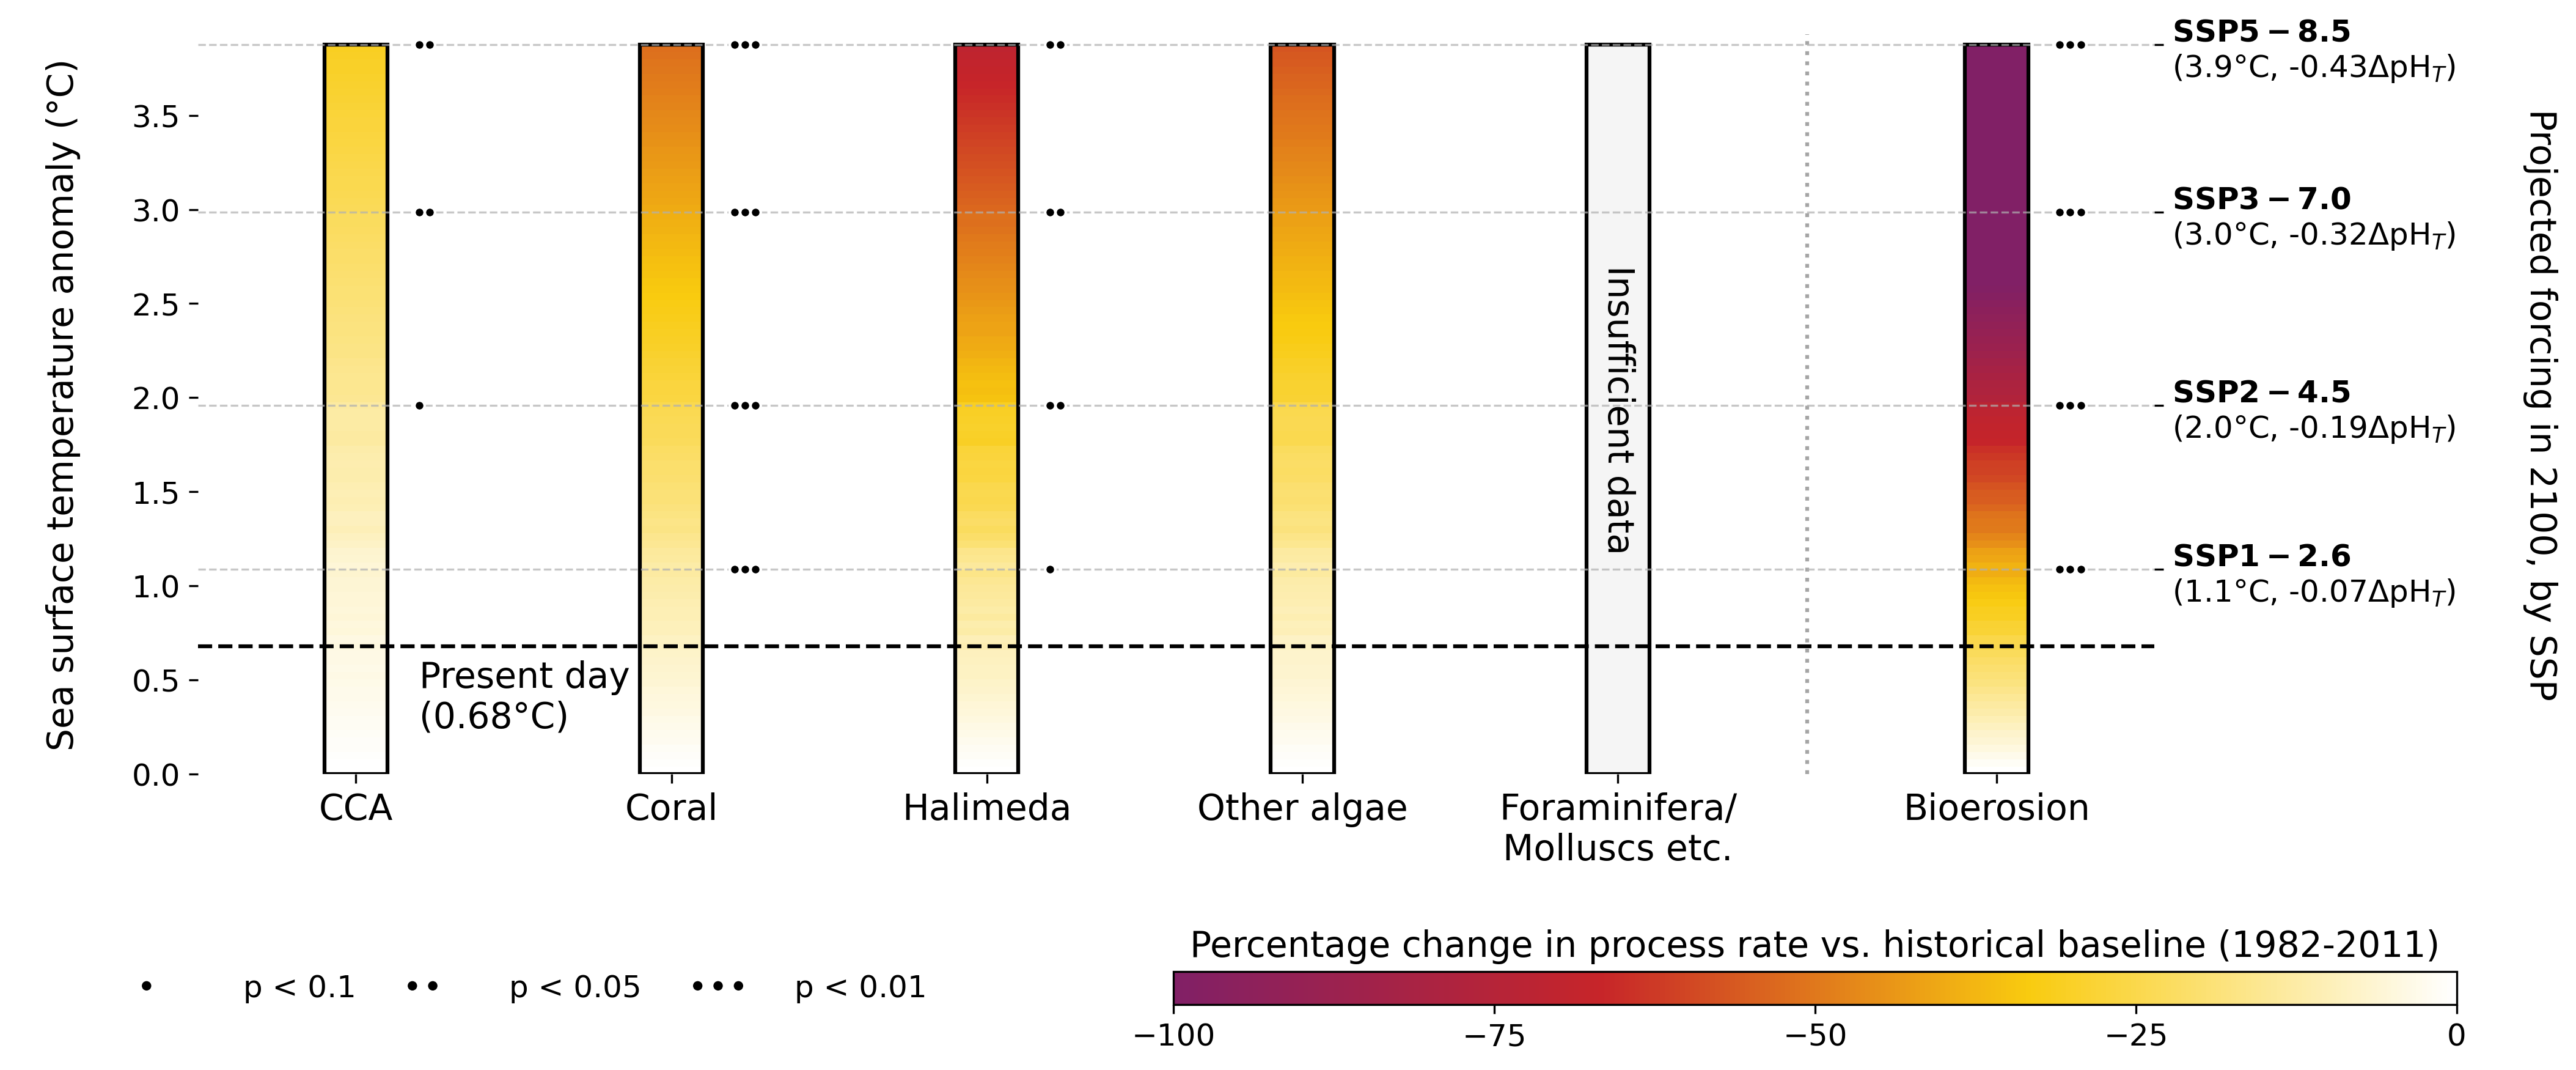

In [26]:
analysis_plot.BurningEmbersPlotter(
    response_df,
    config=analysis_plot.BurningEmbersConfig(
        forcing_col="anomaly_value_sst",
        title="",
        vmin=-100,
        category_order=[
            "CCA",
            "Coral",
            "Halimeda",
            "Other algae",
            "Foraminifera/\nMolluscs etc.",
            "Bioerosion",
        ],
        shift_bioerosion=True,
        pi_exceedance=False,
        se_dots=True,
    ),
).plot();

/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/NREE_persistence_reef_structures_meta_analysis/calcification_meta_analysis/processing/climatology.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(
/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/NREE_persistence_reef_structures_meta_analysis/calcification_meta_analysis/processing/climatology.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(


(<Figure size 7200x600 with 1 Axes>, <Axes: ylabel='Percentage\ncover'>)

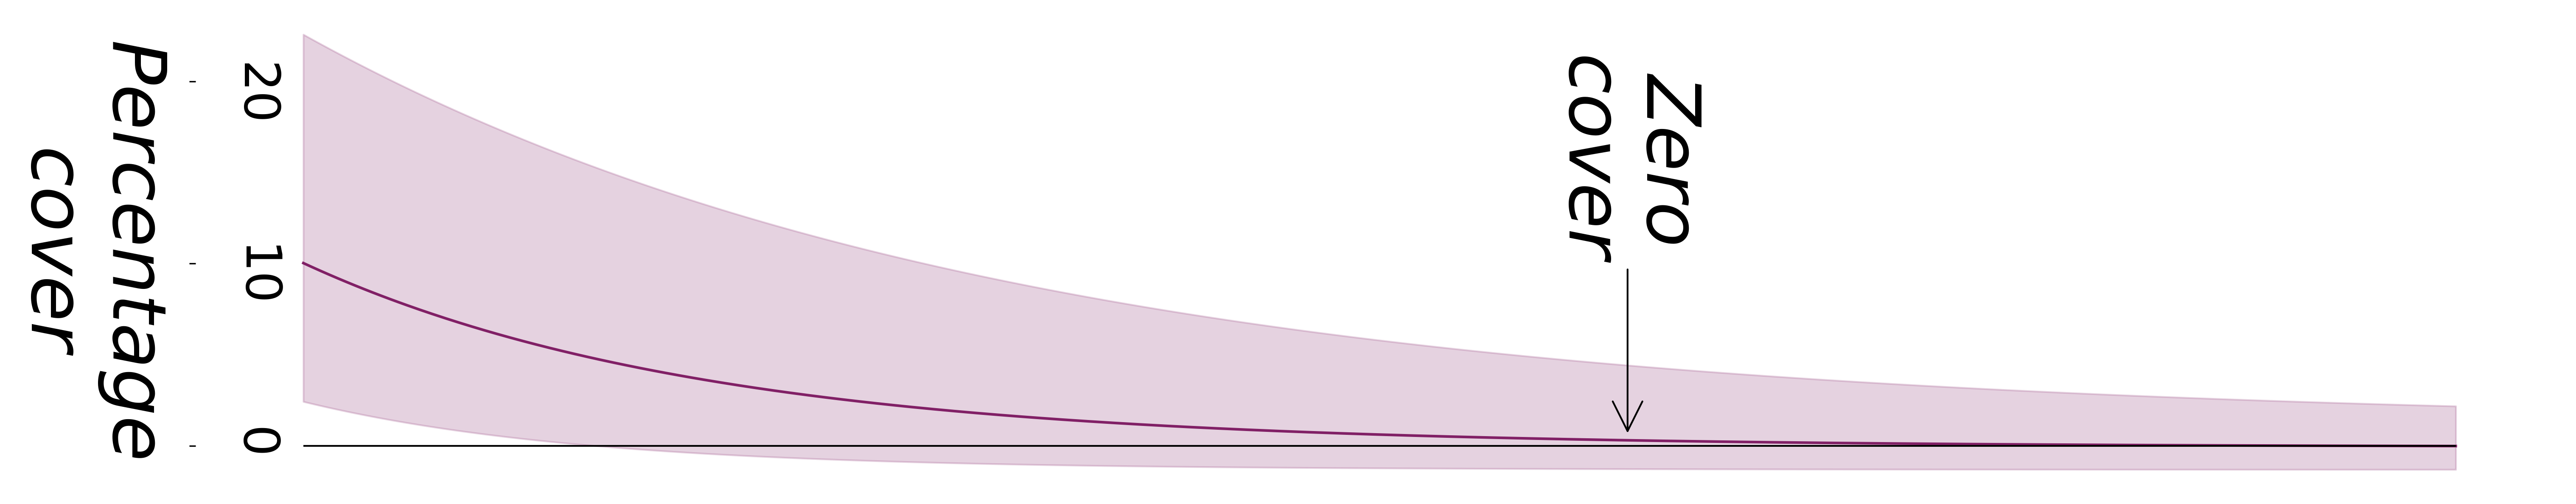

In [27]:
from calcification_meta_analysis.plotting import analysis as analysis_plot

analysis_plot.calculate_and_plot_coral_cover_exponential()